# **Dental Implant 10-Year Survival Prediction**

---
---
# **1.  Brief description of the problem and data**

---
### Overview

In this project, we use deep learning models to predict the 10-year survival of a dental implant for each patient in our dataset. How will our predictions compare with the
$90.94\%$
survival rate seen in the real world?

Models are evaluated primarily on the ROC-AUC score (ROC Area Under the Curve) between the predicted probability and observed target. F1-score is used a secondary metric.

In [1]:
# =============================
# Import libraries
# =============================

# Silence Warnings
import warnings
warnings.filterwarnings("ignore")

# General libraries
import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Visualizations
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# TensorFlow
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
    Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-12-09 00:43:48.171612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765241028.198675   57293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765241028.206737   57293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/kaggle/input/dental-implant-10-year-survival-prediction/sample_submission.csv
/kaggle/input/dental-implant-10-year-survival-prediction/train.csv
/kaggle/input/dental-implant-10-year-survival-prediction/test.csv


In [2]:
# Set random_state for reproducibility
random_state = 86

<br>

---
---
# **2.  Exploratory Data Analysis (EDA)**

---
## Import and Load Data

Our raw data comes in two tabulated tabulated .csv files—one for the train data and one for the test data. Their sizes are:

* **Train Raw:** &ensp;
  ${\color{ForestGreen}{7000}}$ rows × ${\color{MediumSeaGreen}{20}}$ columns
* **Test Raw:** &emsp;
  ${\color{ForestGreen}{3000}}$ rows × ${\color{MediumSeaGreen}{19}}$ columns

The train data has
${\color{MediumSeaGreen}{20}}$
columns listed in the table below. The column `implant_survival_10y` is not available in the test data because our goal is to classify the patients in that dataset with the appropriate prediction regarding the 10-year survival of their dental implant.

| **Column**              | **Meaning**                                                           |
|:------------------------|:----------------------------------------------------------------------|
| `patient_id`            | Unique identifier for each patient.                                   |
| `age`                   | Age of the patient at the time of implant placement.                  |
| `gender`                | Biological sex of the patient.                                        |
| `smoking_status`        | Patient's smoking habits (Non-smoker, Former, Light, Heavy).          |
| `diabetes`              | Presence of diabetes mellitus (0 = No, 1 = Yes).                      |
| `vitamin_d_deficiency`  | Vitamin D deficiency status (0 = No, 1 = Yes).                        |
| `history_periodontitis` | Previous diagnosis of periodontal disease (0 = No, 1 = Yes).          |
| `bruxism`               | Parafunctional grinding/clenching habit (0 = No, 1 = Yes).            |
| `oral_hygiene`          | Patient's oral hygiene status (Good, Fair, Poor).                     |
| `bone_quality`          | Bone density classification (Type_1, Type_2, Type_3, Type_4).         |
| `jaw_location`          | Location of implant placement (Maxilla, Mandible).                    |
| `implant_length_mm`     | Length of the implant in millimeters.                                 |
| `implant_diameter_mm`   | Diameter of the implant in millimeters.                               |
| `implant_surface`       | Surface treatment type of the implant.                                |
| `placement_timing`      | Timing of implant placement after tooth extraction (Immediate, Early, Delayed). |
| `insertion_torque_ncm`  | Rotational force during placement in Newton-centimeters.              |
| `bone_augmentation`     | Whether a bone graft or sinus lift was performed (0 = No, 1 = Yes).   |
| `loading_protocol`      | Timing of prosthetic loading (Immediate, Early, Delayed).             |
| `restoration_type`      | Type of prosthetic restoration (Single_Crown, Bridge, Overdenture).   |
| `implant_survival_10y`  | **(TARGET)** Whether the implant survived for 10 years (0 = Failed, 1 = Survived). |

In [3]:
# =============================
# Load files
# =============================
train_raw = pd.read_csv(
    "/kaggle/input/dental-implant-10-year-survival-prediction/train.csv")
test_raw = pd.read_csv(
    "/kaggle/input/dental-implant-10-year-survival-prediction/test.csv")
sample_submission = pd.read_csv(
    "/kaggle/input/dental-implant-10-year-survival-prediction/sample_submission.csv")

In [4]:
# =============================
# Initial look at data .info()
# =============================

# Check train data
display(HTML(f"<strong>Train Raw Data</strong>"))
train_raw.info()

# Check test data
display(HTML(f"<br><strong>Test Raw Data</strong>"))
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             7000 non-null   int64  
 1   age                    7000 non-null   int64  
 2   gender                 7000 non-null   object 
 3   smoking_status         7000 non-null   object 
 4   diabetes               7000 non-null   int64  
 5   vitamin_d_deficiency   7000 non-null   int64  
 6   history_periodontitis  7000 non-null   int64  
 7   bruxism                7000 non-null   int64  
 8   oral_hygiene           7000 non-null   object 
 9   bone_quality           7000 non-null   object 
 10  jaw_location           7000 non-null   object 
 11  implant_length_mm      7000 non-null   float64
 12  implant_diameter_mm    7000 non-null   float64
 13  implant_surface        7000 non-null   object 
 14  placement_timing       7000 non-null   object 
 15  inse

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             3000 non-null   int64  
 1   age                    3000 non-null   int64  
 2   gender                 3000 non-null   object 
 3   smoking_status         3000 non-null   object 
 4   diabetes               3000 non-null   int64  
 5   vitamin_d_deficiency   3000 non-null   int64  
 6   history_periodontitis  3000 non-null   int64  
 7   bruxism                3000 non-null   int64  
 8   oral_hygiene           3000 non-null   object 
 9   bone_quality           3000 non-null   object 
 10  jaw_location           3000 non-null   object 
 11  implant_length_mm      3000 non-null   float64
 12  implant_diameter_mm    3000 non-null   float64
 13  implant_surface        3000 non-null   object 
 14  placement_timing       3000 non-null   object 
 15  inse

In [5]:
# =============================
# View data .head()
# =============================

# Check train data
display(HTML(f"<strong>Train Raw Data</strong>"))
print(f"Size:    {train_raw.shape[0]} rows × {train_raw.shape[1]} columns")
display(train_raw.head())

# Check test data
display(HTML(f"<br><strong>Test Raw Data</strong>"))
print(f"Size:    {test_raw.shape[0]} rows × {test_raw.shape[1]} columns")
display(test_raw.head())

Size:    7000 rows × 20 columns


,patient_id,age,gender,smoking_status,diabetes,vitamin_d_deficiency,history_periodontitis,bruxism,oral_hygiene,bone_quality,jaw_location,implant_length_mm,implant_diameter_mm,implant_surface,placement_timing,insertion_torque_ncm,bone_augmentation,loading_protocol,restoration_type,implant_survival_10y
0,6253,83,Male,Non-smoker,0,0,1,0,Fair,Type_2,Maxilla,8.3,4.1,SLA,Delayed,29,0,Early,Single_Crown,1
1,4685,39,Female,Former,0,0,0,0,Fair,Type_2,Maxilla,11.4,4.5,SLA,Delayed,16,0,Immediate,Bridge,1
2,1732,47,Male,Light,0,0,1,1,Fair,Type_2,Maxilla,13.7,4.1,SLA,Delayed,39,1,Immediate,Bridge,1
3,4743,52,Male,Non-smoker,0,0,0,1,Poor,Type_2,Mandible,13.0,4.9,SLActive,Delayed,41,0,Delayed,Single_Crown,1
4,4522,64,Male,Light,0,0,1,1,Fair,Type_1,Maxilla,11.9,3.5,SLA,Early,63,1,Delayed,Single_Crown,1


Size:    3000 rows × 19 columns


,patient_id,age,gender,smoking_status,diabetes,vitamin_d_deficiency,history_periodontitis,bruxism,oral_hygiene,bone_quality,jaw_location,implant_length_mm,implant_diameter_mm,implant_surface,placement_timing,insertion_torque_ncm,bone_augmentation,loading_protocol,restoration_type
0,5526,44,Male,Non-smoker,0,0,0,0,Good,Type_2,Mandible,10.8,3.2,TiUnite,Delayed,37,1,Delayed,Single_Crown
1,772,45,Male,Non-smoker,0,0,0,0,Good,Type_1,Mandible,10.3,4.6,TiUnite,Delayed,43,1,Early,Single_Crown
2,7840,47,Male,Non-smoker,0,0,1,1,Fair,Type_1,Mandible,12.9,4.3,SLA,Early,51,0,Delayed,Single_Crown
3,2396,34,Male,Non-smoker,0,1,0,0,Good,Type_2,Maxilla,15.2,4.9,SLActive,Delayed,43,0,Immediate,Single_Crown
4,1479,41,Female,Former,0,0,0,0,Fair,Type_3,Maxilla,12.4,4.1,SLA,Delayed,39,0,Delayed,Single_Crown


In [6]:
# ============================
# Check for dupes and nulls.
# ============================

# Check train_raw
display(HTML(f"<strong>Train Raw Data</strong>"))
print(f"Size:    {train_raw.shape[0]} rows × {train_raw.shape[1]} columns")
train_duplicates = train_raw.duplicated().sum()
print(f"Number of duplicates:    {train_duplicates}")
train_nulls = train_raw.isnull().sum().sum()
print(f"Number of nulls:         {train_nulls}")

# Check test_raw
display(HTML(f"<br><strong>Test Raw Data</strong>"))
print(f"Size:    {test_raw.shape[0]} rows × {test_raw.shape[1]} columns")
test_duplicates = test_raw.duplicated().sum()
print(f"Number of duplicates:    {test_duplicates}")
test_nulls = test_raw.isnull().sum().sum()
print(f"Number of nulls:         {test_nulls}")

Size:    7000 rows × 20 columns
Number of duplicates:    0
Number of nulls:         0


Size:    3000 rows × 19 columns
Number of duplicates:    0
Number of nulls:         0


---
## Data Preprocessing

I looked over my variables again and manually assigned them to groups. Additionally, I manually assigned variables to encodings based on their `dtype`. The table below shows this hierarchical organization. From here, we sliced our train and test data into separate slices based on their group + encoding.

> I did this because I initially planned on building a 1D convolution model with each of these group + encoding categories feeding into a separate covolutional layer. When I ran my MLP model, I quickly learned that too many layers was asking for overfitting. But this made my visualizations cleaner.

| **group**      | **encodings** | **meaning**                    | **variables** |
|:---------------|:--------------|:-------------------------------|:--------------|
| **id**         | id            | primary key patient identifier | `patient_id` |
| **pt**         | binary        | patient-related factors        | `diabetes`, `vitamin_d_deficiency` |
|                | categorical   |                                | `gender`, `smoking_status` |
|                | numeric       |                                | `age` |
| **clinical**   | binary        | clinical and intraoral factors | `history_periodontitis`, `bruxism` |
|                | categorical   |                                | `oral_hygiene`, `bone_quality`, `jaw_location` |
| **implant**    | categorical   | implant-related factors        | `implant_surface` |
|                | numeric       |                                | `implant_length_mm`, `implant_diameter_mm` |
| **surgical**   | binary        | surgical factors               | `bone_augmentation` |
|                | categorical   |                                | `placement_timing` |
|                | numeric       |                                | `insertion_torque_ncm` |
| **prosthetic** | categorical   | prosthetic factors             | `loading_protocol`, `restoration_type` |
| **target**     | binary        | target variable                | `implant_survival_10y` |

In [7]:
# =============================
# Generate group + encoding
# =============================
def generate_group_encoding(df, id_cols=None, group_mapping=None):
    if group_mapping is None:
        group_mapping = {}   
    df_copy = df.copy()
    meta_list = []
    for col in df_copy.columns:
        dtype = df_copy[col].dtype
        n_unique = df_copy[col].nunique()
        unique_values = df_copy[col].unique().tolist()
        
        # Encoding types
        if col in id_cols:
            encoding = "id"
        elif dtype == "object":
            encoding = "categorical"
        elif n_unique == 2 and set(df_copy[col].dropna().unique()).issubset({0,1}):
            encoding = "binary"
        else:
            encoding = "numeric"
        # Group types
        group = group_mapping.get(col, None)
        meta_list.append({
            "var": col,
            "dtype": str(dtype),
            "n_unique": n_unique,
            "unique_values": unique_values,
            "encoding": encoding,
            "group": group
        })    
    meta_df = pd.DataFrame(meta_list)
    return meta_df


# Custom group mapping
group_mapping = {
    "patient_id": "id",
    "age": "pt",
    "gender": "pt",
    "smoking_status": "pt",
    "diabetes": "pt",
    "vitamin_d_deficiency": "pt",
    "history_periodontitis": "clinical",
    "bruxism": "clinical",
    "oral_hygiene": "clinical",
    "bone_quality": "clinical",
    "jaw_location": "clinical",
    "implant_length_mm": "implant",
    "implant_diameter_mm": "implant",
    "implant_surface": "implant",
    "placement_timing": "surgical",
    "insertion_torque_ncm": "surgical",
    "bone_augmentation": "surgical",
    "loading_protocol": "prosthetic",
    "restoration_type": "prosthetic",
    "implant_survival_10y": "target"
}


# -----------------------------
# Get group + encodings for train
# -----------------------------
train_group_encoding_df = generate_group_encoding(train_raw, id_cols=["patient_id"],
                                                  group_mapping=group_mapping)


# -----------------------------
# Get group + encodings for test
# -----------------------------
test_group_encoding_df = generate_group_encoding(test_raw, id_cols=["patient_id"],
                                                 group_mapping=group_mapping)

In [8]:
# =============================
# Slice train by group + encoding
# =============================
train_full = train_raw.copy()

# Create a dict mapping column -> group + encoding
train_col_group = train_group_encoding_df.set_index("var")["group"].to_dict()
train_col_encoding = train_group_encoding_df.set_index("var")["encoding"].to_dict()
train_full._meta_group = train_col_group
train_full._meta_encoding = train_col_encoding

# Dictionary of columns by group & encoding
train_cols_by_group_encoding = {
    (grp, enc): train_group_encoding_df[
        (train_group_encoding_df["group"] == grp) &
        (train_group_encoding_df["encoding"] == enc)
    ]["var"].tolist()
    for grp in train_group_encoding_df["group"].unique()
    for enc in train_group_encoding_df["encoding"].unique()
}


# -----------------------------
# Get train slices
# -----------------------------
# id
train_cols_id_id = train_cols_by_group_encoding.get(("id", "id"), [])

# pt
train_cols_pt_binary = train_cols_by_group_encoding.get(
    ("pt", "binary"), [])
train_cols_pt_categorical = train_cols_by_group_encoding.get(("pt", "categorical"), [])
train_cols_pt_numeric = train_cols_by_group_encoding.get(
    ("pt", "numeric"), [])

# clinical
train_cols_clinical_binary = train_cols_by_group_encoding.get(
    ("clinical", "binary"), [])
train_cols_clinical_categorical = train_cols_by_group_encoding.get(
    ("clinical", "categorical"), [])

# implant
train_cols_implant_categorical = train_cols_by_group_encoding.get(
    ("implant", "categorical"), [])
train_cols_implant_numeric = train_cols_by_group_encoding.get(
    ("implant", "numeric"), [])

# surgical
train_cols_surgical_binary = train_cols_by_group_encoding.get(
    ("surgical", "binary"), [])
train_cols_surgical_categorical = train_cols_by_group_encoding.get(
    ("surgical", "categorical"), [])
train_cols_surgical_numeric = train_cols_by_group_encoding.get(
    ("surgical", "numeric"), [])

# prosthetic
train_cols_prosthetic_categorical = train_cols_by_group_encoding.get(
    ("prosthetic", "categorical"), [])

# target
train_cols_target_target = train_cols_by_group_encoding.get(("target", "binary"), [])

In [9]:
# =============================
# Slice test by group + encoding
# =============================
test_set = test_raw.copy()

# Create a dict mapping column -> group + encoding
test_col_group = test_group_encoding_df.set_index("var")["group"].to_dict()
test_col_encoding = test_group_encoding_df.set_index("var")["encoding"].to_dict()
test_set._meta_group = test_col_group
test_set._meta_encoding = test_col_encoding

# Dictionary of columns by group & encoding
test_cols_by_group_encoding = {
    (grp, enc): test_group_encoding_df[
        (test_group_encoding_df["group"] == grp) &
        (test_group_encoding_df["encoding"] == enc)
    ]["var"].tolist()
    for grp in test_group_encoding_df["group"].unique()
    for enc in test_group_encoding_df["encoding"].unique()
}


# -----------------------------
# Get test slices
# -----------------------------
# id
test_cols_id_id = test_cols_by_group_encoding.get(("id", "id"), [])

# pt
test_cols_pt_binary = test_cols_by_group_encoding.get(
    ("pt", "binary"), [])
test_cols_pt_categorical = test_cols_by_group_encoding.get(
    ("pt", "categorical"), [])
test_cols_pt_numeric = test_cols_by_group_encoding.get(("pt", "numeric"), [])

# clinical
test_cols_clinical_binary = test_cols_by_group_encoding.get(
    ("clinical", "binary"), [])
test_cols_clinical_categorical = test_cols_by_group_encoding.get(
    ("clinical", "categorical"), [])

# implant
test_cols_implant_categorical = test_cols_by_group_encoding.get(
    ("implant", "categorical"), [])
test_cols_implant_numeric = test_cols_by_group_encoding.get(
    ("implant", "numeric"), [])

# surgical
test_cols_surgical_binary = test_cols_by_group_encoding.get(
    ("surgical", "binary"), [])
test_cols_surgical_categorical = test_cols_by_group_encoding.get(
    ("surgical", "categorical"), [])
test_cols_surgical_numeric = test_cols_by_group_encoding.get(
    ("surgical", "numeric"), [])

# prosthetic
test_cols_prosthetic_categorical = test_cols_by_group_encoding.get(
    ("prosthetic", "categorical"), [])

---
## Visualize Data

Next, we checked our `train_raw` data to get the counts of implants that failed after 10 years vs. those that survived. Our data reflects the real-world survival rate of
$\approx 91\%$
mentioned in our problem description. We plotted a bar chart and pie chart to show this distribution.

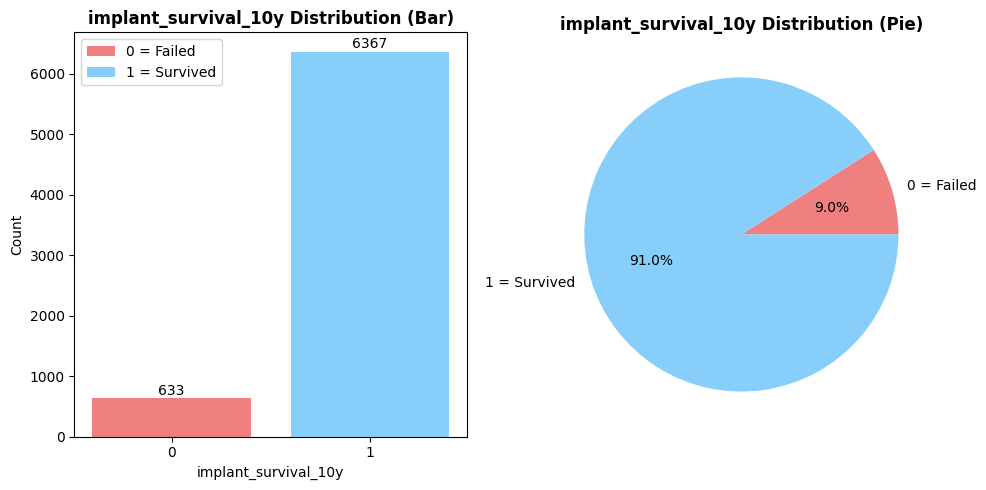

In [10]:
# =============================
# Counts of implant survival at 10 years
# =============================
train_full = train_raw.copy()
display(HTML(f"<strong>Train Full Data</strong>"))
train_labels = train_full.columns[-1]
counts = (train_full[train_labels].value_counts().reindex([0, 1]))

# -----------------------------
# Plot implant survival at 10 years
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
legend_labels = ["0 = Failed", "1 = Survived"]

# Bar chart
bars = axes[0].bar(counts.index.astype(str), counts.values,
                   color=["LightCoral", "LightSkyBlue"])
axes[0].set_title(f"{train_labels} Distribution (Bar)", weight="bold")
axes[0].set_xlabel(train_labels)
axes[0].set_ylabel("Count")
axes[0].legend(bars, legend_labels)
for bar in bars:
    height = bar.get_height()
    axes[0].annotate(
        f"{height}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 0.5),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

# Pie chart
axes[1].pie(counts.values, autopct="%1.1f%%",
            colors=["LightCoral", "LightSkyBlue"], labels=legend_labels)
axes[1].set_title(f"{train_labels} Distribution (Pie)", weight="bold")

plt.tight_layout()
plt.show()

> ---

The next several visualizations plot the counts and distributions of our variables across our train data set. Plots are organized by `group` and `encoding`.

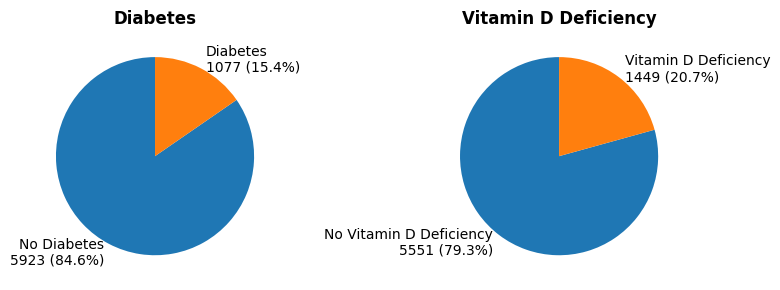

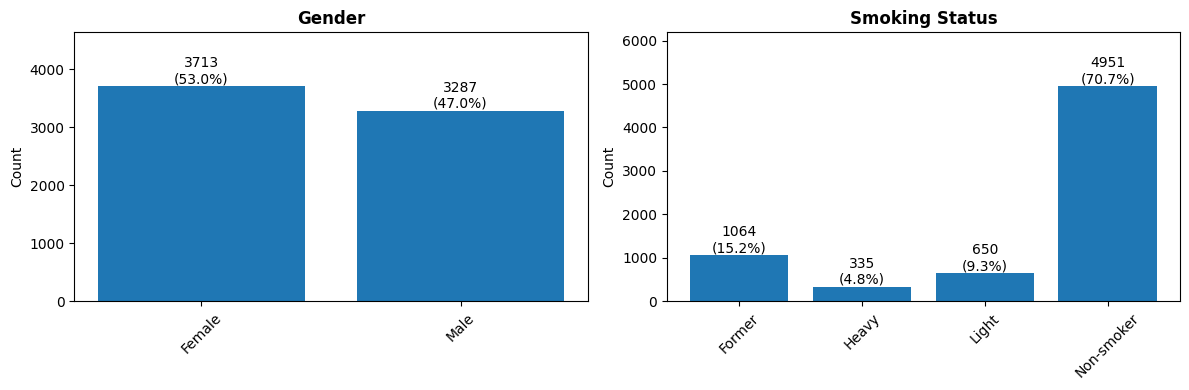

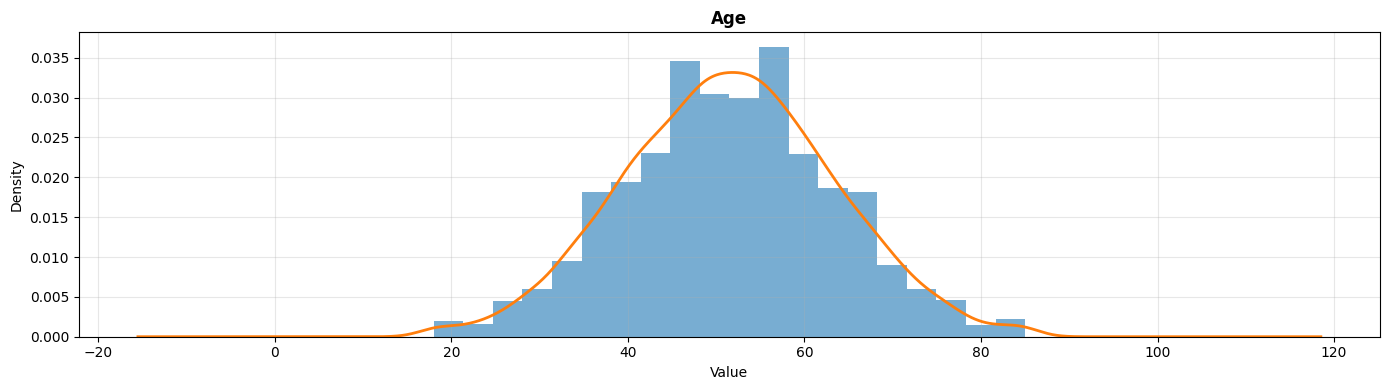

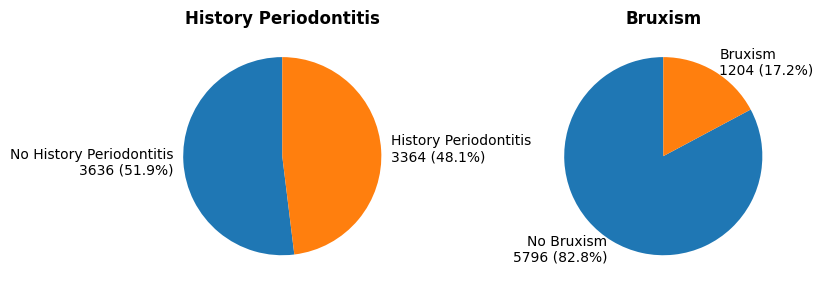

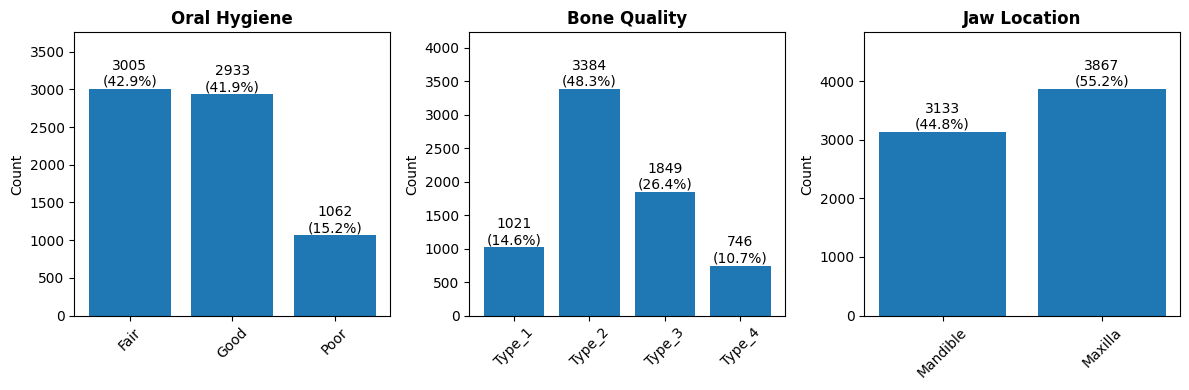

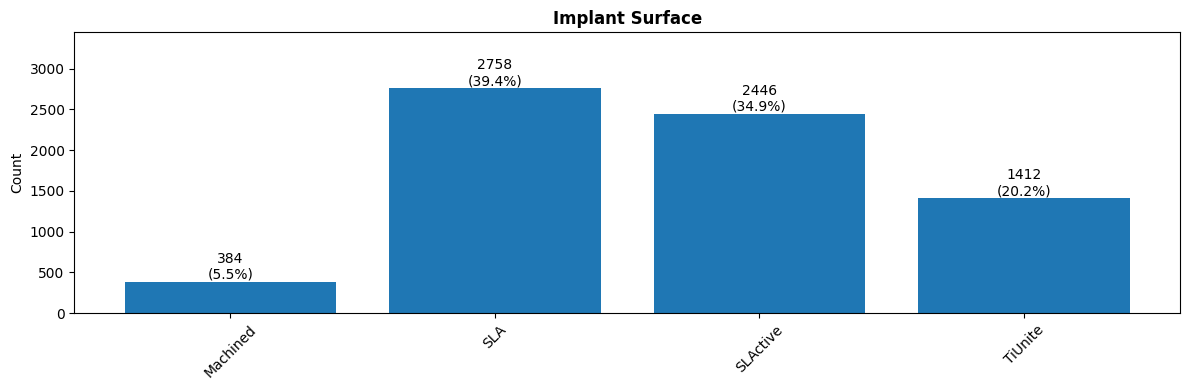

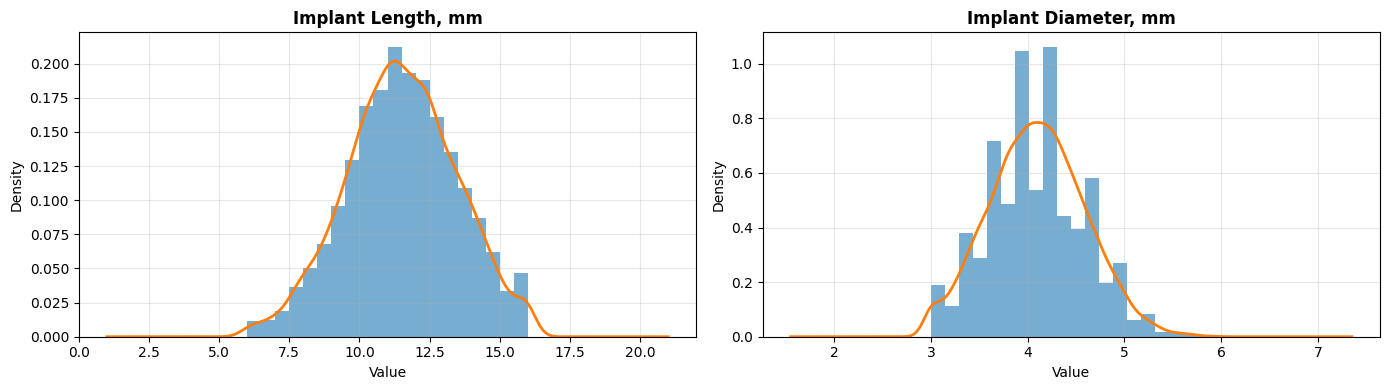

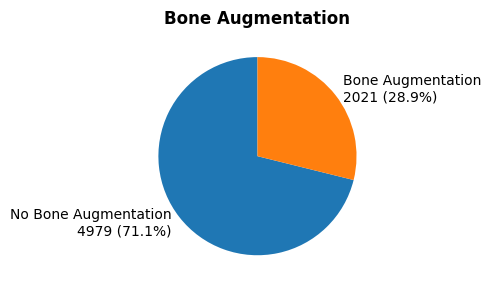

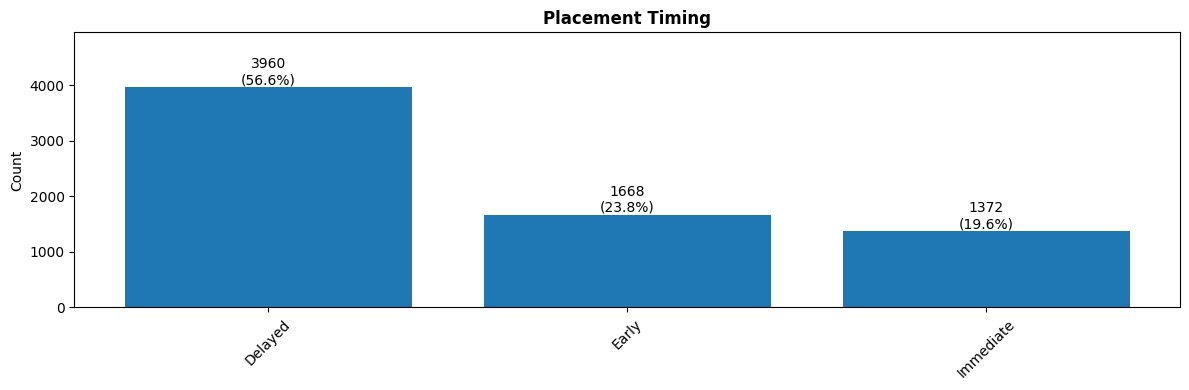

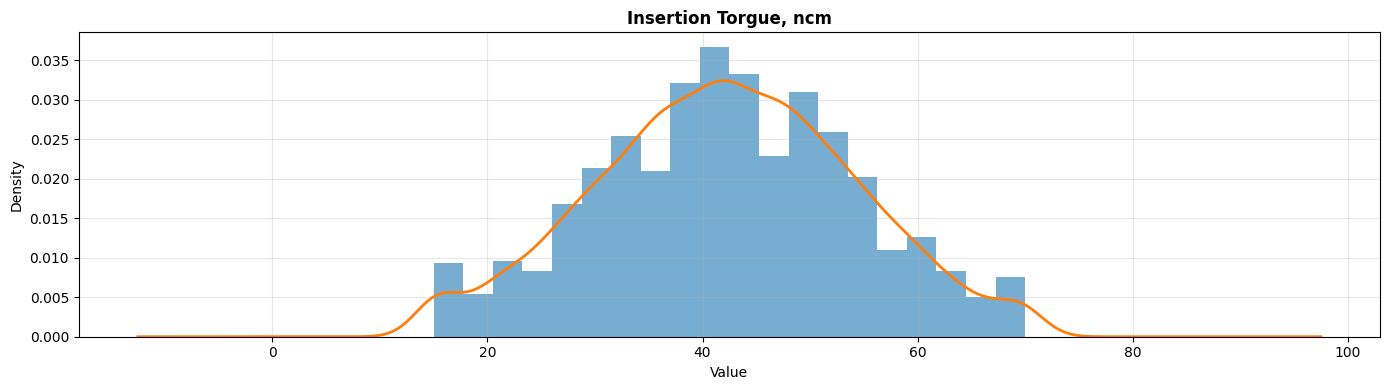

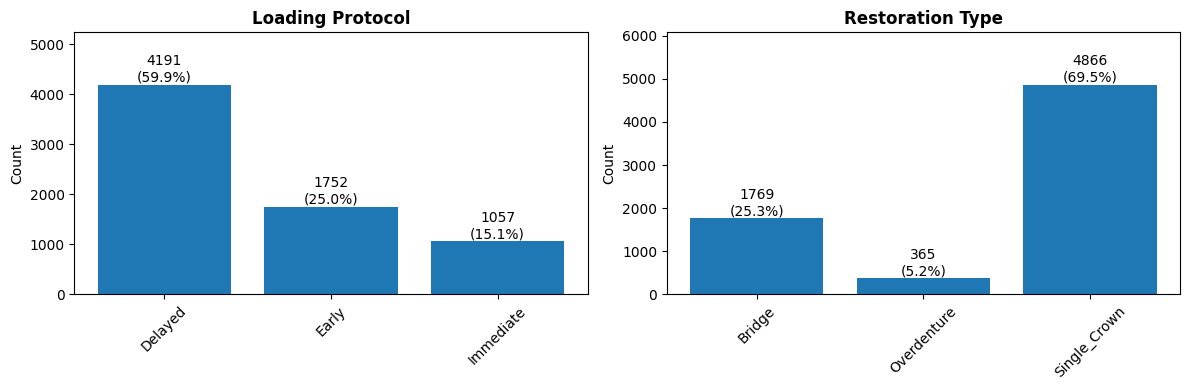

In [11]:
# =============================
# Visualizations by group + encoding
# =============================

# -----------------------------
# pt
# -----------------------------
# pt : binary — pie charts
display(HTML(f"<strong>Train Full Data &emsp; pt : binary</strong>"))
pt_binary_vars = [
    ("Diabetes", train_cols_pt_binary[0]),
    ("Vitamin D Deficiency", train_cols_pt_binary[1]),
]
fig, axes = plt.subplots(1, len(pt_binary_vars), figsize=(8, 3))
if len(pt_binary_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, pt_binary_vars):
    counts = train_full[col].value_counts().reindex([0,1])
    labels = [f"No {var_name}", f"{var_name}"]
    ax.pie(
        counts,
        labels=[f"{lab}\n{cnt} ({cnt / counts.sum():.1%})"
                for lab, cnt in zip(labels, counts)],
        autopct=None,
        startangle=90
    )
    ax.set_title(var_name, weight="bold")
plt.tight_layout()
plt.show()

# pt : categorical — bar plots
display(HTML(f"<strong>Train Full Data &emsp; pt : categorical</strong>"))
pt_categorical_vars = [
    ("Gender", train_cols_pt_categorical[0]),
    ("Smoking Status", train_cols_pt_categorical[1]),
]
fig, axes = plt.subplots(1, len(pt_categorical_vars), figsize=(12, 4))
if len(pt_categorical_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, pt_categorical_vars):
    counts = train_full[col].value_counts().sort_index()
    total  = counts.sum()
    labels = counts.index.tolist()
    bars = ax.bar(labels, counts)
    for b, cnt in zip(bars, counts):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{cnt}\n({cnt/total:.1%})",
            ha="center", va="bottom"
        )
    ax.set_title(var_name, weight="bold")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, counts.max() * 1.25)
plt.tight_layout()
plt.show()

# pt : numeric — distribution (histogram + KDE)
display(HTML(f"<strong>Train Full Data &emsp; pt : numeric</strong>"))
pt_numeric_vars = [
    ("Age", train_cols_pt_numeric[0]),
]
fig, axes = plt.subplots(1, len(pt_numeric_vars), figsize=(14, 4))
if len(pt_numeric_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, pt_numeric_vars):
    data = train_full[col].dropna()
    ax.hist(data, bins=20, density=True, alpha=0.6)
    kde = data.plot(kind="kde", ax=ax, linewidth=2)
    ax.set_title(var_name, weight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


display(HTML(f"<br><br><blockquote><hr></blockquote>"))


# -----------------------------
# clinical
# -----------------------------
# clinical : binary — pie charts
display(HTML(f"<br><br><strong>Train Full Data &emsp; clinical : binary</strong>"))
clinical_binary_vars = [
    ("History Periodontitis", train_cols_clinical_binary[0]),
    ("Bruxism", train_cols_clinical_binary[1]),
]
fig, axes = plt.subplots(1, len(clinical_binary_vars), figsize=(8, 3))
if len(clinical_binary_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, clinical_binary_vars):
    counts = train_full[col].value_counts().reindex([0,1])
    labels = [f"No {var_name}", f"{var_name}"]
    ax.pie(
        counts,
        labels=[f"{lab}\n{cnt} ({cnt / counts.sum():.1%})"
                for lab, cnt in zip(labels, counts)],
        autopct=None,
        startangle=90
    )
    ax.set_title(var_name, weight="bold")
plt.tight_layout()
plt.show()

# clinical : categorical — bar plots
display(HTML(f"<strong>Train Full Data &emsp; clinical : categorical</strong>"))
clinical_categorical_vars = [
    ("Oral Hygiene", train_cols_clinical_categorical[0]),
    ("Bone Quality", train_cols_clinical_categorical[1]),
    ("Jaw Location", train_cols_clinical_categorical[2]),
]
fig, axes = plt.subplots(1, len(clinical_categorical_vars), figsize=(12, 4))
if len(clinical_categorical_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, clinical_categorical_vars):
    counts = train_full[col].value_counts().sort_index()
    total  = counts.sum()
    labels = counts.index.tolist()
    bars = ax.bar(labels, counts)
    for b, cnt in zip(bars, counts):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{cnt}\n({cnt/total:.1%})",
            ha="center", va="bottom"
        )
    ax.set_title(var_name, weight="bold")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, counts.max() * 1.25)
plt.tight_layout()
plt.show()


display(HTML(f"<br><br><blockquote><hr></blockquote>"))


# -----------------------------
# implant
# -----------------------------
# implant : categorical — bar plots
display(HTML(f"<br><br><strong>Train Full Data &emsp; implant : categorical</strong>"))
implant_categorical_vars = [
    ("Implant Surface", train_cols_implant_categorical[0]),
]
fig, axes = plt.subplots(1, len(implant_categorical_vars), figsize=(12, 4))
if len(implant_categorical_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, implant_categorical_vars):
    counts = train_full[col].value_counts().sort_index()
    total  = counts.sum()
    labels = counts.index.tolist()
    bars = ax.bar(labels, counts)
    for b, cnt in zip(bars, counts):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{cnt}\n({cnt/total:.1%})",
            ha="center", va="bottom"
        )
    ax.set_title(var_name, weight="bold")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, counts.max() * 1.25)
plt.tight_layout()
plt.show()

# pt : implant — distribution (histogram + KDE)
display(HTML(f"<strong>Train Full Data &emsp; implant : numeric</strong>"))
implant_numeric_vars = [
    ("Implant Length, mm", train_cols_implant_numeric[0]),
    ("Implant Diameter, mm", train_cols_implant_numeric[1]),
]
fig, axes = plt.subplots(1, len(implant_numeric_vars), figsize=(14, 4))
if len(implant_numeric_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, implant_numeric_vars):
    data = train_full[col].dropna()
    ax.hist(data, bins=20, density=True, alpha=0.6)
    kde = data.plot(kind="kde", ax=ax, linewidth=2)
    ax.set_title(var_name, weight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


display(HTML(f"<br><br><blockquote><hr></blockquote>"))


# -----------------------------
# surgical
# -----------------------------
# surgical : binary — pie charts
display(HTML(f"<br><br><strong>Train Full Data &emsp; surgical : binary</strong>"))
surgical_binary_vars = [
    ("Bone Augmentation", train_cols_surgical_binary[0]),
]
fig, axes = plt.subplots(1, len(surgical_binary_vars), figsize=(8, 3))
if len(surgical_binary_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, surgical_binary_vars):
    counts = train_full[col].value_counts().reindex([0,1])
    labels = [f"No {var_name}", f"{var_name}"]
    ax.pie(
        counts,
        labels=[f"{lab}\n{cnt} ({cnt / counts.sum():.1%})"
                for lab, cnt in zip(labels, counts)],
        autopct=None,
        startangle=90
    )
    ax.set_title(var_name, weight="bold")
plt.tight_layout()
plt.show()

# surgical : categorical — bar plots
display(HTML(f"<strong>Train Full Data &emsp; surgical : categorical</strong>"))
surgical_categorical_vars = [
    ("Placement Timing", train_cols_surgical_categorical[0]),
]
fig, axes = plt.subplots(1, len(surgical_categorical_vars), figsize=(12, 4))
if len(surgical_categorical_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, surgical_categorical_vars):
    counts = train_full[col].value_counts().sort_index()
    total  = counts.sum()
    labels = counts.index.tolist()
    bars = ax.bar(labels, counts)
    for b, cnt in zip(bars, counts):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{cnt}\n({cnt/total:.1%})",
            ha="center", va="bottom"
        )
    ax.set_title(var_name, weight="bold")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, counts.max() * 1.25)
plt.tight_layout()
plt.show()

# surgical : numeric — distribution (histogram + KDE)
display(HTML(f"<strong>Train Full Data &emsp; surgical : numeric</strong>"))
surgical_numeric_vars = [
    ("Insertion Torgue, ncm", train_cols_surgical_numeric[0]),
]
fig, axes = plt.subplots(1, len(surgical_numeric_vars), figsize=(14, 4))
if len(surgical_numeric_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, surgical_numeric_vars):
    data = train_full[col].dropna()
    ax.hist(data, bins=20, density=True, alpha=0.6)
    kde = data.plot(kind="kde", ax=ax, linewidth=2)
    ax.set_title(var_name, weight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


display(HTML(f"<br><br><blockquote><hr></blockquote>"))


# -----------------------------
# protesthetic
# -----------------------------
# prosthetic : categorical — bar plots
display(HTML(f"<br><br><strong>Train Full Data &emsp; prosthetic : categorical</strong>"))
prosthetic_categorical_vars = [
    ("Loading Protocol", train_cols_prosthetic_categorical[0]),
    ("Restoration Type", train_cols_prosthetic_categorical[1]),
]
fig, axes = plt.subplots(1, len(prosthetic_categorical_vars), figsize=(12, 4))
if len(prosthetic_categorical_vars) == 1:
    axes = [axes]
for ax, (var_name, col) in zip(axes, prosthetic_categorical_vars):
    counts = train_full[col].value_counts().sort_index()
    total  = counts.sum()
    labels = counts.index.tolist()
    bars = ax.bar(labels, counts)
    for b, cnt in zip(bars, counts):
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height(),
            f"{cnt}\n({cnt/total:.1%})",
            ha="center", va="bottom"
        )
    ax.set_title(var_name, weight="bold")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, counts.max() * 1.25)
plt.tight_layout()
plt.show()

> ---

From here, we split our sliced up train data into a train set and a validation set. We also created a test set out of test data.

In [12]:
# =============================
# Train + Val Split
# =============================
train_set, val_set = train_test_split(
    train_full,
    test_size=0.2,
    random_state=86,
    # Stratify on target (implant_survival_10y)
    stratify=train_full["implant_survival_10y"]
)

# Feature metadata with group + encoding
feature_meta = train_group_encoding_df.set_index("var").drop((), errors="ignore")

# Scaler for numeric features
scaler = StandardScaler()
numeric_cols = train_cols_pt_numeric + train_cols_implant_numeric + train_cols_surgical_numeric


# -----------------------------
# Train Set
# -----------------------------
X_train = train_set.drop(columns=["implant_survival_10y", "patient_id"])
# One-hot encoding
X_train_enc = pd.get_dummies(X_train, columns=train_cols_pt_categorical + 
                                          train_cols_clinical_categorical + 
                                          train_cols_implant_categorical + 
                                          train_cols_surgical_categorical +
                                          train_cols_prosthetic_categorical)
X_train_enc[numeric_cols] = scaler.fit_transform(X_train_enc[numeric_cols])
X_train_enc = X_train_enc.astype("float32")
y_train = train_set["implant_survival_10y"]
display(HTML(f"<strong>Train Set</strong>"))
print(f"Size:    {train_set.shape[0]} rows × {train_set.shape[1]} columns")
print(train_set["implant_survival_10y"].value_counts(normalize=True))


# -----------------------------
# Valid Set
# -----------------------------
X_val = val_set.drop(columns=["implant_survival_10y", "patient_id"])
# One-hot encoding
X_val_enc = pd.get_dummies(X_val, columns=train_cols_pt_categorical + 
                                        train_cols_clinical_categorical + 
                                        train_cols_implant_categorical + 
                                        train_cols_surgical_categorical +
                                        train_cols_prosthetic_categorical)
X_val_enc[numeric_cols] = scaler.transform(X_val_enc[numeric_cols])
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)
X_val_enc   = X_val_enc.astype("float32")
y_val = val_set["implant_survival_10y"]
display(HTML(f"<br><strong>Val Set</strong>"))
print(f"Size:    {val_set.shape[0]} rows × {val_set.shape[1]} columns")
print(train_set["implant_survival_10y"].value_counts(normalize=True))

# -----------------------------
# Test Set
# -----------------------------
X_test = test_set.drop(columns=["patient_id"])
# One-hot encoding
X_test_enc = pd.get_dummies(X_test, columns=test_cols_pt_categorical + 
                                        test_cols_clinical_categorical + 
                                        test_cols_implant_categorical + 
                                        test_cols_surgical_categorical +
                                        test_cols_prosthetic_categorical)
X_test_enc[numeric_cols] = scaler.transform(X_test_enc[numeric_cols])
X_test_enc  = X_test_enc.astype("float32")
display(HTML(f"<br><strong>Test Set</strong>"))
print(f"Size:    {test_set.shape[0]} rows × {test_set.shape[1]} columns")

Size:    5600 rows × 20 columns
implant_survival_10y
1    0.909643
0    0.090357
Name: proportion, dtype: float64


Size:    1400 rows × 20 columns
implant_survival_10y
1    0.909643
0    0.090357
Name: proportion, dtype: float64


Size:    3000 rows × 19 columns


<br>

---
---
# **3.  Model Architecture**

---
## Define Parameters

We will be testing our models against these hyperparameters

| **dropout_rate <br>(from MLP)** | **learning_rate <br>(from Adam optimizer)**           |
|:--------------------------------|:------------------------------------------------------|
| ${\color{Gray}{0.2}}$           | ${\color{HotPink}{\eta}} = {\color{HotPink}{0.001}}$  |
| ${\color{Gray}{0.2}}$           | ${\color{HotPink}{\eta}} = {\color{HotPink}{0.0005}}$ |
| ${\color{Gray}{0.3}}$           | ${\color{HotPink}{\eta}} = {\color{HotPink}{0.001}}$  |
| ${\color{Gray}{0.3}}$           | ${\color{HotPink}{\eta}} = {\color{HotPink}{0.0005}}$ |

Because our data was stratitifed to reflect the highly uneven real-world distribution of implant survival rates at 10 years
($9 \%$ failure vs. $90 \%$ survival), we create a `class_weights_dictionary` to balance this out.

In [13]:
# -------------------------
# Class weights dictionary
# -------------------------
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

---
## General MLP Model Architecture

From here, we developed a series of MLP models, each with varying numbers of hidden units in their
${\color{CornflowerBlue}{\textsf{Dense Layers}}}$.

  * MLP 1: &emsp;
    ${\color{CornflowerBlue}{h}}_{1}
        = [ {\color{CornflowerBlue}{256}}, {\color{CornflowerBlue}{128}} ]$
  * MLP 2: &emsp;
    ${\color{CornflowerBlue}{h}}_{2}
        = [ {\color{CornflowerBlue}{64}}, {\color{CornflowerBlue}{32}} ]$
  * MLP 3: &emsp;
    ${\color{CornflowerBlue}{h}}_{3}
        = [ {\color{CornflowerBlue}{16}}, {\color{CornflowerBlue}{8}} ]$
  * MLP 4: &emsp;
    ${\color{CornflowerBlue}{h}}_{4}
        = [ {\color{CornflowerBlue}{4}}, {\color{CornflowerBlue}{2}} ]$

All versions of our model have ${\color{ForestGreen}{n}
    = \color{ForestGreen}{7}}$
layers, listed below. The
${\color{MediumSeaGreen}{2 \textsf{ non-trainable layers}}}$
are marked in MediumSeaGreen, and the
${\color{CornflowerBlue}{5 \textsf{ trainable layers}}}$
are marked in CornflowerBlue. Differences betwen models are found in 

> 0. ${\color{MediumSeaGreen}{\texttt{Input Layer}}}$ <br>
>    Receives all input features.
>
> 1. ${\color{CornflowerBlue}{\texttt{Dense Layer 1 }}}
        ( {\color{CornflowerBlue}{h}}_{{\color{Gray}{i}} \, (1)} 
            {\color{CornflowerBlue}{\textsf{ units}}} )$ <br>
>    First fully connected layer with
     ${\color{CornflowerBlue}{h}}_{{\color{Gray}{i}} \, (1)}$
     hidden states. Uses the activation function "ReLU" and L2 regularization to shrink weights and reduce overfitting. Its role is to learn the first level of non-linear feature interactions between our variables.
>
> 2. ${\color{CornflowerBlue}{\texttt{Batch Normalization 1}}}$ <br>
>    Normalizes activations from the previous dense layer. Stabilizes training in small datasets like ours.
>
> 3. ${\color{MediumSeaGreen}{\texttt{Dropout 1}}}$ <br>
>    Regularization layer to prevent overfitting. Dropout rate of
     $[ {\color{Gray}{0.2}}, \; {\color{Gray}{0.3}} ]$
     is applied here, depending on iteration.
>
> 4. ${\color{CornflowerBlue}{\texttt{Dense Layer 2 }}}
        ( {\color{CornflowerBlue}{h}}_{{\color{Gray}{i}} \, (2)} 
            {\color{CornflowerBlue}{\textsf{ units}}} )$ <br>
>    Second fully connected layer with
     ${\color{CornflowerBlue}{h}}_{{\color{Gray}{i}} \, (2)}$
     hidden states. Works the same way as the previous dense layer and go deeper on non-linear feature interactions between our variables.
>
> 5. ${\color{CornflowerBlue}{\texttt{Batch Normalization 2}}}$ <br>
>    Normalizes activations from the previous dense layer.
>
> 6. ${\color{MediumSeaGreen}{\texttt{Dropout 2}}}$ <br>
>    Regularization layer to prevent overfitting. Dropout rate of
     $[ {\color{Gray}{0.2}}, {\color{Gray}{0.3}} ]$
     is applied here, depending on iteration.
>
> 7. ${\color{CornflowerBlue}{\texttt{Output Layer}}}$ <br>
>    Single Dense neuron that uses the sigmoid activation function to give an output btween 0 and 1 representing the probability of implant survival at 10 years.

We compile our model using the following:
* **Optimizer:** Adam. Learning rate
  ${\color{HotPink}{\eta}}
      = [ {\color{HotPink}{0.001}}, {\color{HotPink}{0.0005}} ]$
  is applied here, depending on iteration.
* **Loss Function:** binary_crossentropy (because we're expecting binary output)
* **Metrics:** ROC_AUC, F1-score

In [14]:
# =========================
# MLP 1;    h = [256, 128]
# =========================
def build_mlp_1(input_shape, hidden_units=[256, 128], dropout=0.3, l2_reg=1e-4):

    # 0. Input Layer
    inp = Input(shape=(input_shape,), name="mlp_input")
    x = inp
    
    for idx, i in enumerate(hidden_units):
        # 1, 4. Dense Layer
        x = Dense(i, activation="relu", kernel_regularizer=l2(l2_reg))(x)
        
        # 2, 5. Batch Normalization
        x = BatchNormalization()(x)
        
        # 3, 6. Dropout 
        x = Dropout(dropout)(x)

    # 7. Output Layer
    out = Dense(1, activation="sigmoid", name="out")(x)
    
    model = Model(inp, out, name="MLP")
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy",
                           Precision(name="prec"), Recall(name="rec")])
    return model

In [15]:
# =========================
# MLP 2,    h = [64, 32]
# =========================
def build_mlp_2(input_shape, hidden_units=[64, 32], dropout=0.3, l2_reg=1e-4):

    # 0. Input Layer
    inp = Input(shape=(input_shape,), name="mlp_input")
    x = inp
    
    for idx, i in enumerate(hidden_units):
        # 1, 4. Dense Layer
        x = Dense(i, activation="relu", kernel_regularizer=l2(l2_reg))(x)
        
        # 2, 5. Batch Normalization
        x = BatchNormalization()(x)
        
        # 3, 6. Dropout 
        x = Dropout(dropout)(x)

    # 7. Output Layer
    out = Dense(1, activation="sigmoid", name="out")(x)
    
    model = Model(inp, out, name="MLP")
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy",
                           Precision(name="prec"), Recall(name="rec")])
    return model

In [16]:
# =========================
# MLP 3,    h = [16, 8]
# =========================
def build_mlp_3(input_shape, hidden_units=[16, 8], dropout=0.3, l2_reg=1e-4):

    # 0. Input Layer
    inp = Input(shape=(input_shape,), name="mlp_input")
    x = inp
    
    for idx, i in enumerate(hidden_units):
        # 1, 4. Dense Layer
        x = Dense(i, activation="relu", kernel_regularizer=l2(l2_reg))(x)
        
        # 2, 5. Batch Normalization
        x = BatchNormalization()(x)
        
        # 3, 6. Dropout 
        x = Dropout(dropout)(x)

    # 7. Output Layer
    out = Dense(1, activation="sigmoid", name="out")(x)
    
    model = Model(inp, out, name="MLP")
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy",
                           Precision(name="prec"), Recall(name="rec")])
    return model

In [17]:
# =========================
# MLP 4,    h = [4, 2]
# =========================
def build_mlp_4(input_shape, hidden_units=[4, 2], dropout=0.3, l2_reg=1e-4):

    # 0. Input Layer
    inp = Input(shape=(input_shape,), name="mlp_input")
    x = inp
    
    for idx, i in enumerate(hidden_units):
        # 1, 4. Dense Layer
        x = Dense(i, activation="relu", kernel_regularizer=l2(l2_reg))(x)
        
        # 2, 5. Batch Normalization
        x = BatchNormalization()(x)
        
        # 3, 6. Dropout 
        x = Dropout(dropout)(x)

    # 7. Output Layer
    out = Dense(1, activation="sigmoid", name="out")(x)
    
    model = Model(inp, out, name="MLP")
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy",
                           Precision(name="prec"), Recall(name="rec")])
    return model

<br>

---
---
# **4.  Results and Analysis**

---
We ran our each of our MLP models across
${\color{Sienna}{k}}
    = {\color{Sienna}{80}}$
epochs, but applied `tf.keras.callbacks.EarlyStopping()` to avoid overfitting. We also applied a
${\color{Sienna}{k}}
    = {\color{Sienna}{5}}$ cross-fold validation to deal with overfitting on our small dataset.
    
For each of our parameter groups, we chose the model iterations that would give us the best ROC_AUC score for our validation set, and plotted them below. Our train set is plotted in RoyalBlue and our validation set is plotted in Crimson. ROC_AUC scores are marked with a circle and solid lines, while F1-scores are marked with a square and dashed lines. We highlighted the values for the best model in Plum.

---
## MLP 1, &ensp; $h = [256, 128]$

We found our highest validation set ROC_AUC score when our dropout rate was set to
${\color{Gray}{0.2}}$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0001}}$.

However, ROC_AUC score for our train set was almost always
$1.0$,
while it hovered around
$0.53$
for our validation set. This tell us our model was badly overfitting.

In [18]:
# =========================
# Tuning MLP 1 on 5-fold CV
# =========================
dropouts = [0.2, 0.3]
learning_rates = [0.001, 0.0005]
k_folds = 5

mlp_1_cv_summary = []

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for do in dropouts:
    for lr in learning_rates:
        display(HTML(f"<br><strong>Training MLP 1, &ensp; h = [256, 128]"
                     f"&ensp; with dropout={do}, lr={lr}</strong><br>"))        
        
        fold_train_roc_auc = []
        fold_val_roc_auc = []
        fold_train_f1 = []
        fold_val_f1 = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_enc, y_train)):
            X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Build & compile model
            model = build_mlp_1(input_shape=X_train_enc.shape[1], dropout=do)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss="binary_crossentropy",
                          metrics=[tf.keras.metrics.AUC(name="auc"),
                                   Precision(name="prec"),
                                   Recall(name="rec")])

            early_stop = EarlyStopping(
            monitor="val_roc_auc",
            patience=8,
            mode="max",
            restore_best_weights=True
            )
            
            # Train
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=80,
                batch_size=64,
                verbose=0,
                class_weight=class_weights_dict,
                callbacks=[early_stop] 
            )

            # Predict
            train_probs = model.predict(X_tr, verbose=0).flatten()
            val_probs = model.predict(X_val, verbose=0).flatten()
            train_preds = (train_probs > 0.5).astype(int)
            val_preds = (val_probs > 0.5).astype(int)

            # Compute metrics
            tr_roc_auc = roc_auc_score(y_tr, train_probs)
            val_roc_auc = roc_auc_score(y_val, val_probs)
            tr_f1 = f1_score(y_tr, train_preds)
            val_f1 = f1_score(y_val, val_preds)
            
            fold_train_roc_auc.append(tr_roc_auc)
            fold_val_roc_auc.append(val_roc_auc)
            fold_train_f1.append(tr_f1)
            fold_val_f1.append(val_f1)

            # Track best ROC-AUC for this fold
            print(f"\nFold {fold+1}:")
            print(f"   Train ROC-AUC: {tr_roc_auc:.4f} | Train F1: {tr_f1:.4f}")
            print(f"   Val   ROC-AUC: {val_roc_auc:.4f} | Val   F1: {val_f1:.4f}")

            # Confusion matrix for this fold
            cm = confusion_matrix(y_val, val_preds)
            print("    Confusion Matrix (Val):")
            print(cm)

        # Save mean metrics across folds
        mlp_1_cv_summary.append({
            "dropout_rate": do,
            "lr": lr,
            "train_roc_auc_mean": np.mean(fold_train_roc_auc),
            "val_roc_auc_mean": np.mean(fold_val_roc_auc),
            "train_f1_mean": np.mean(fold_train_f1),
            "val_f1_mean": np.mean(fold_val_f1),
        })

# Convert to DataFrame
mlp_1_cv_df = pd.DataFrame(mlp_1_cv_summary)

# Highlight best mean val ROC-AUC
def highlight_best_val_roc_auc(row):
    if row["val_roc_auc_mean"] == mlp_1_cv_df["val_roc_auc_mean"].max():
        return ["background-color: #F4DCF3"]*len(row)
    return [""]*len(row)


display(HTML(f"<br><strong>Training MLP 1, &ensp; h = [256, 128]"
                     f"&ensp; HyperParameter Summary</strong><br>"))  
display(mlp_1_cv_df.style.apply(highlight_best_val_roc_auc, axis=1))

2025-12-09 00:46:51.738515: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Fold 1:
   Train ROC-AUC: 1.0000 | Train F1: 0.9970
   Val   ROC-AUC: 0.5906 | Val   F1: 0.9164
    Confusion Matrix (Val):
[[ 12  89]
 [ 82 937]]

Fold 2:
   Train ROC-AUC: 1.0000 | Train F1: 0.9970
   Val   ROC-AUC: 0.5061 | Val   F1: 0.9143
    Confusion Matrix (Val):
[[ 11  90]
 [ 85 934]]

Fold 3:
   Train ROC-AUC: 0.9998 | Train F1: 0.9962
   Val   ROC-AUC: 0.5771 | Val   F1: 0.9076
    Confusion Matrix (Val):
[[  9  92]
 [ 96 923]]

Fold 4:
   Train ROC-AUC: 1.0000 | Train F1: 0.9972
   Val   ROC-AUC: 0.5248 | Val   F1: 0.9205
    Confusion Matrix (Val):
[[  6  95]
 [ 69 950]]

Fold 5:
   Train ROC-AUC: 1.0000 | Train F1: 0.9975
   Val   ROC-AUC: 0.5689 | Val   F1: 0.9121
    Confusion Matrix (Val):
[[ 12  90]
 [ 89 929]]



Fold 1:
   Train ROC-AUC: 1.0000 | Train F1: 0.9917
   Val   ROC-AUC: 0.5716 | Val   F1: 0.9034
    Confusion Matrix (Val):
[[ 13  88]
 [107 912]]

Fold 2:
   Train ROC-AUC: 0.9999 | Train F1: 0.9954
   Val   ROC-AUC: 0.5049 | Val   F1: 0.9127
    Confusion Matrix (Val):
[[ 12  89]
 [ 89 930]]

Fold 3:
   Train ROC-AUC: 1.0000 | Train F1: 0.9958
   Val   ROC-AUC: 0.5202 | Val   F1: 0.9094
    Confusion Matrix (Val):
[[ 12  89]
 [ 95 924]]

Fold 4:
   Train ROC-AUC: 1.0000 | Train F1: 0.9970
   Val   ROC-AUC: 0.5230 | Val   F1: 0.9124
    Confusion Matrix (Val):
[[  9  92]
 [ 87 932]]

Fold 5:
   Train ROC-AUC: 1.0000 | Train F1: 0.9951
   Val   ROC-AUC: 0.5204 | Val   F1: 0.9087
    Confusion Matrix (Val):
[[ 14  88]
 [ 97 921]]



Fold 1:
   Train ROC-AUC: 0.9996 | Train F1: 0.9921
   Val   ROC-AUC: 0.5500 | Val   F1: 0.9108
    Confusion Matrix (Val):
[[  9  92]
 [ 90 929]]

Fold 2:
   Train ROC-AUC: 0.9998 | Train F1: 0.9930
   Val   ROC-AUC: 0.5080 | Val   F1: 0.9028
    Confusion Matrix (Val):
[[  8  93]
 [104 915]]

Fold 3:
   Train ROC-AUC: 0.9999 | Train F1: 0.9931
   Val   ROC-AUC: 0.5480 | Val   F1: 0.9080
    Confusion Matrix (Val):
[[ 16  85]
 [101 918]]

Fold 4:
   Train ROC-AUC: 0.9997 | Train F1: 0.9926
   Val   ROC-AUC: 0.5597 | Val   F1: 0.9123
    Confusion Matrix (Val):
[[ 22  79]
 [ 98 921]]

Fold 5:
   Train ROC-AUC: 0.9998 | Train F1: 0.9912
   Val   ROC-AUC: 0.5637 | Val   F1: 0.8948
    Confusion Matrix (Val):
[[ 17  85]
 [125 893]]



Fold 1:
   Train ROC-AUC: 0.9997 | Train F1: 0.9866
   Val   ROC-AUC: 0.5592 | Val   F1: 0.9074
    Confusion Matrix (Val):
[[ 11  90]
 [ 98 921]]

Fold 2:
   Train ROC-AUC: 0.9990 | Train F1: 0.9868
   Val   ROC-AUC: 0.5007 | Val   F1: 0.8941
    Confusion Matrix (Val):
[[  8  93]
 [120 899]]

Fold 3:
   Train ROC-AUC: 0.9997 | Train F1: 0.9848
   Val   ROC-AUC: 0.5550 | Val   F1: 0.9015
    Confusion Matrix (Val):
[[ 10  91]
 [108 911]]

Fold 4:
   Train ROC-AUC: 0.9998 | Train F1: 0.9892
   Val   ROC-AUC: 0.5237 | Val   F1: 0.9110
    Confusion Matrix (Val):
[[ 13  88]
 [ 93 926]]

Fold 5:
   Train ROC-AUC: 0.9994 | Train F1: 0.9809
   Val   ROC-AUC: 0.5466 | Val   F1: 0.9026
    Confusion Matrix (Val):
[[ 21  81]
 [114 904]]


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean
0,0.200000,0.001000,0.999937,0.553517,0.996997,0.914193
1,0.200000,0.000500,0.999951,0.528002,0.995015,0.909328
2,0.300000,0.001000,0.999758,0.545903,0.992384,0.905746
3,0.300000,0.000500,0.999506,0.537038,0.985656,0.903324


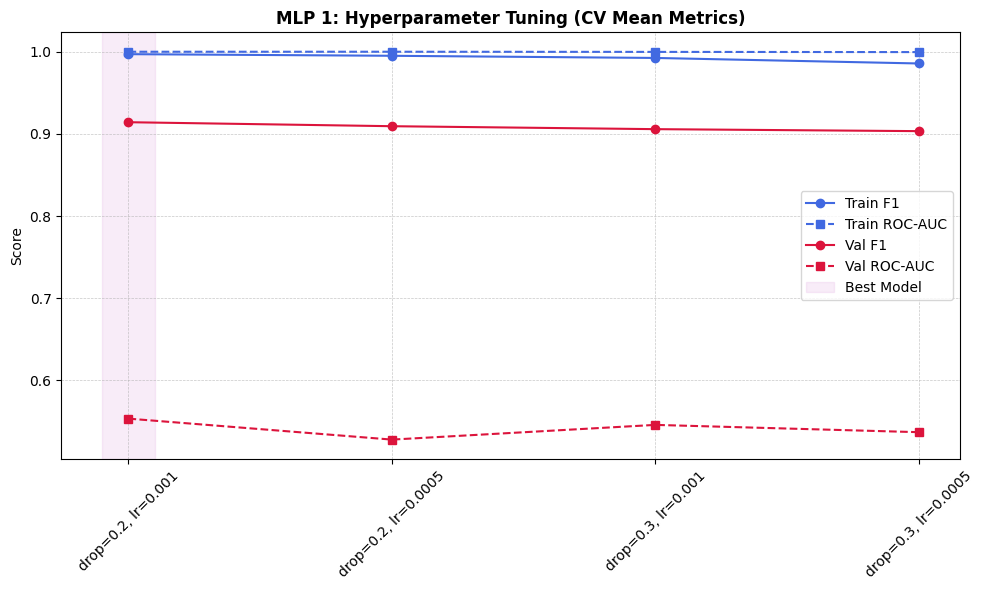

In [19]:
# ========================
# Plot MLP 1 CV Results
# ========================
mlp_1_cv_df["label"] = mlp_1_cv_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(mlp_1_cv_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, mlp_1_cv_df["train_f1_mean"], marker="o", linestyle="-",
         color="RoyalBlue", label="Train F1")
plt.plot(x, mlp_1_cv_df["train_roc_auc_mean"], marker="s", linestyle="--",
         color="RoyalBlue", label="Train ROC-AUC")

# Validation metrics
plt.plot(x, mlp_1_cv_df["val_f1_mean"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, mlp_1_cv_df["val_roc_auc_mean"], marker="s", linestyle="--",
         color="Crimson", label="Val ROC-AUC")

# Highlight best model by val ROC-AUC
best_idx = mlp_1_cv_df["val_roc_auc_mean"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, mlp_1_cv_df["label"], rotation=45)
plt.title("MLP 1: Hyperparameter Tuning (CV Mean Metrics)", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

---
## MLP 2, &ensp; $h = [64, 32]$

This time, we found our highest validation set ROC_AUC score when our dropout rate was set to
${\color{Gray}{0.3}}$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$.

However, results from our coss validation folds still show that the train set ROC_AUC score hovers at around
$0.96$,
while the validation was still close to
$0.56$,
so our model still suffers from overfitting.

In [20]:
# =========================
# Tuning MLP 2 on 5-fold CV
# =========================
dropouts = [0.2, 0.3]
learning_rates = [0.001, 0.0005]
k_folds = 5

mlp_2_cv_summary = []

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for do in dropouts:
    for lr in learning_rates:
        display(HTML(f"<br><strong>Training MLP 2, &ensp; h = [64, 32]"
                     f"&ensp; with dropout={do}, lr={lr}</strong><br>"))        
        
        fold_train_roc_auc = []
        fold_val_roc_auc = []
        fold_train_f1 = []
        fold_val_f1 = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_enc, y_train)):
            X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Build & compile model
            model = build_mlp_2(input_shape=X_train_enc.shape[1], dropout=do)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss="binary_crossentropy",
                          metrics=[tf.keras.metrics.AUC(name="auc"),
                                   Precision(name="prec"),
                                   Recall(name="rec")])

            early_stop = EarlyStopping(
            monitor="val_roc_auc",
            patience=8,
            mode="max",
            restore_best_weights=True
            )
            
            # Train
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=80,
                batch_size=64,
                verbose=0,
                class_weight=class_weights_dict,
                callbacks=[early_stop] 
            )

            # Predict
            train_probs = model.predict(X_tr, verbose=0).flatten()
            val_probs = model.predict(X_val, verbose=0).flatten()
            train_preds = (train_probs > 0.5).astype(int)
            val_preds = (val_probs > 0.5).astype(int)

            # Compute metrics
            tr_roc_auc = roc_auc_score(y_tr, train_probs)
            val_roc_auc = roc_auc_score(y_val, val_probs)
            tr_f1 = f1_score(y_tr, train_preds)
            val_f1 = f1_score(y_val, val_preds)
            
            fold_train_roc_auc.append(tr_roc_auc)
            fold_val_roc_auc.append(val_roc_auc)
            fold_train_f1.append(tr_f1)
            fold_val_f1.append(val_f1)

            # Track best ROC-AUC for this fold
            print(f"\nFold {fold+1}:")
            print(f"   Train ROC-AUC: {tr_roc_auc:.4f} | Train F1: {tr_f1:.4f}")
            print(f"   Val   ROC-AUC: {val_roc_auc:.4f} | Val   F1: {val_f1:.4f}")

            # Confusion matrix for this fold
            cm = confusion_matrix(y_val, val_preds)
            print("    Confusion Matrix (Val):")
            print(cm)

        # Save mean metrics across folds
        mlp_2_cv_summary.append({
            "dropout_rate": do,
            "lr": lr,
            "train_roc_auc_mean": np.mean(fold_train_roc_auc),
            "val_roc_auc_mean": np.mean(fold_val_roc_auc),
            "train_f1_mean": np.mean(fold_train_f1),
            "val_f1_mean": np.mean(fold_val_f1),
        })

# Convert to DataFrame
mlp_2_cv_df = pd.DataFrame(mlp_2_cv_summary)

# Highlight best mean val ROC-AUC
def highlight_best_val_roc_auc(row):
    if row["val_roc_auc_mean"] == mlp_2_cv_df["val_roc_auc_mean"].max():
        return ["background-color: #F4DCF3"]*len(row)
    return [""]*len(row)

display(HTML(f"<br><strong>Training MLP 2, &ensp; h = [64, 32]"
                     f"&ensp; HyperParameter Summary</strong><br>"))   
display(mlp_2_cv_df.style.apply(highlight_best_val_roc_auc, axis=1))


Fold 1:
   Train ROC-AUC: 0.9860 | Train F1: 0.9101
   Val   ROC-AUC: 0.5869 | Val   F1: 0.8294
    Confusion Matrix (Val):
[[ 36  65]
 [251 768]]

Fold 2:
   Train ROC-AUC: 0.9892 | Train F1: 0.9466
   Val   ROC-AUC: 0.5345 | Val   F1: 0.8616
    Confusion Matrix (Val):
[[ 18  83]
 [185 834]]

Fold 3:
   Train ROC-AUC: 0.9874 | Train F1: 0.9074
   Val   ROC-AUC: 0.5605 | Val   F1: 0.8252
    Confusion Matrix (Val):
[[ 31  70]
 [254 765]]

Fold 4:
   Train ROC-AUC: 0.9794 | Train F1: 0.9396
   Val   ROC-AUC: 0.5561 | Val   F1: 0.8607
    Confusion Matrix (Val):
[[ 28  73]
 [194 825]]

Fold 5:
   Train ROC-AUC: 0.9839 | Train F1: 0.9372
   Val   ROC-AUC: 0.5590 | Val   F1: 0.8324
    Confusion Matrix (Val):
[[ 23  79]
 [236 782]]



Fold 1:
   Train ROC-AUC: 0.9484 | Train F1: 0.8935
   Val   ROC-AUC: 0.5465 | Val   F1: 0.8221
    Confusion Matrix (Val):
[[ 31  70]
 [259 760]]

Fold 2:
   Train ROC-AUC: 0.9635 | Train F1: 0.9136
   Val   ROC-AUC: 0.5194 | Val   F1: 0.8427
    Confusion Matrix (Val):
[[ 24  77]
 [221 798]]

Fold 3:
   Train ROC-AUC: 0.9582 | Train F1: 0.9102
   Val   ROC-AUC: 0.5912 | Val   F1: 0.8567
    Confusion Matrix (Val):
[[ 31  70]
 [203 816]]

Fold 4:
   Train ROC-AUC: 0.9604 | Train F1: 0.9248
   Val   ROC-AUC: 0.5330 | Val   F1: 0.8526
    Confusion Matrix (Val):
[[ 26  75]
 [206 813]]

Fold 5:
   Train ROC-AUC: 0.9589 | Train F1: 0.8897
   Val   ROC-AUC: 0.5806 | Val   F1: 0.8149
    Confusion Matrix (Val):
[[ 38  64]
 [274 744]]



Fold 1:
   Train ROC-AUC: 0.9626 | Train F1: 0.9062
   Val   ROC-AUC: 0.6212 | Val   F1: 0.8493
    Confusion Matrix (Val):
[[ 32  69]
 [216 803]]

Fold 2:
   Train ROC-AUC: 0.9686 | Train F1: 0.8908
   Val   ROC-AUC: 0.5428 | Val   F1: 0.7960
    Confusion Matrix (Val):
[[ 31  70]
 [299 720]]

Fold 3:
   Train ROC-AUC: 0.9588 | Train F1: 0.9072
   Val   ROC-AUC: 0.5316 | Val   F1: 0.8439
    Confusion Matrix (Val):
[[ 24  77]
 [219 800]]

Fold 4:
   Train ROC-AUC: 0.9608 | Train F1: 0.9131
   Val   ROC-AUC: 0.5602 | Val   F1: 0.8426
    Confusion Matrix (Val):
[[ 28  73]
 [224 795]]

Fold 5:
   Train ROC-AUC: 0.9669 | Train F1: 0.9090
   Val   ROC-AUC: 0.5605 | Val   F1: 0.8220
    Confusion Matrix (Val):
[[ 28  74]
 [256 762]]



Fold 1:
   Train ROC-AUC: 0.9208 | Train F1: 0.8777
   Val   ROC-AUC: 0.5819 | Val   F1: 0.8271
    Confusion Matrix (Val):
[[ 38  63]
 [256 763]]

Fold 2:
   Train ROC-AUC: 0.9177 | Train F1: 0.8764
   Val   ROC-AUC: 0.5413 | Val   F1: 0.8105
    Confusion Matrix (Val):
[[ 31  70]
 [277 742]]

Fold 3:
   Train ROC-AUC: 0.9173 | Train F1: 0.8352
   Val   ROC-AUC: 0.5901 | Val   F1: 0.7828
    Confusion Matrix (Val):
[[ 47  54]
 [329 690]]

Fold 4:
   Train ROC-AUC: 0.9088 | Train F1: 0.8398
   Val   ROC-AUC: 0.5478 | Val   F1: 0.7695
    Confusion Matrix (Val):
[[ 39  62]
 [343 676]]

Fold 5:
   Train ROC-AUC: 0.9281 | Train F1: 0.8840
   Val   ROC-AUC: 0.5588 | Val   F1: 0.8129
    Confusion Matrix (Val):
[[ 32  70]
 [273 745]]


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean
0,0.200000,0.001000,0.985178,0.559396,0.928203,0.841853
1,0.200000,0.000500,0.957882,0.554134,0.906349,0.837793
2,0.300000,0.001000,0.963525,0.563268,0.905271,0.830760
3,0.300000,0.000500,0.918561,0.563967,0.862625,0.800542


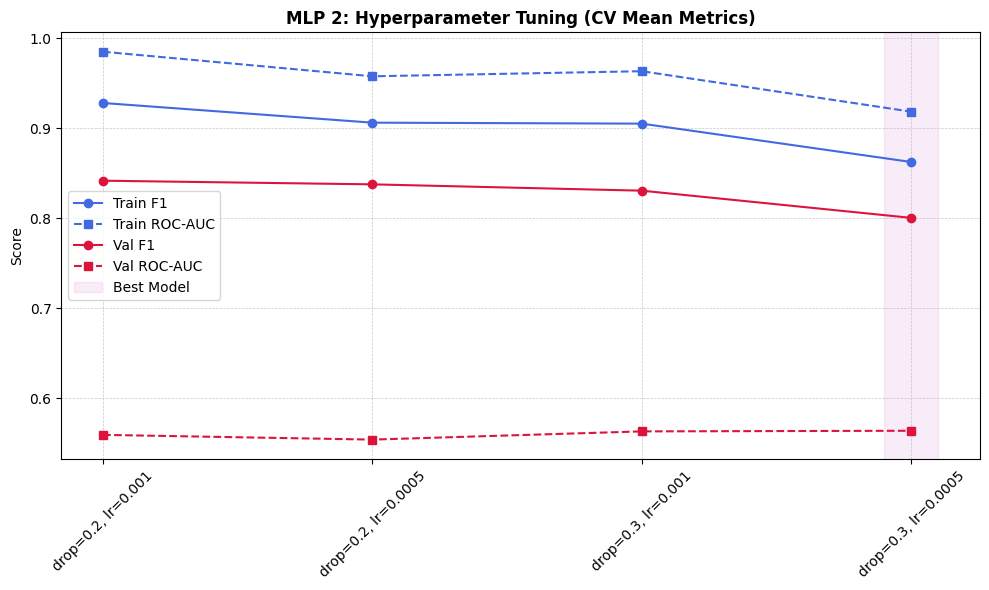

In [21]:
# ========================
# Plot MLP 2 CV Results
# ========================
mlp_2_cv_df["label"] = mlp_2_cv_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(mlp_2_cv_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, mlp_2_cv_df["train_f1_mean"], marker="o", linestyle="-",
         color="RoyalBlue", label="Train F1")
plt.plot(x, mlp_2_cv_df["train_roc_auc_mean"], marker="s", linestyle="--",
         color="RoyalBlue", label="Train ROC-AUC")

# Validation metrics
plt.plot(x, mlp_2_cv_df["val_f1_mean"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, mlp_2_cv_df["val_roc_auc_mean"], marker="s", linestyle="--",
         color="Crimson", label="Val ROC-AUC")

# Highlight best model by val ROC-AUC
best_idx = mlp_2_cv_df["val_roc_auc_mean"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, mlp_2_cv_df["label"], rotation=45)
plt.title("MLP 2: Hyperparameter Tuning (CV Mean Metrics)", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

---
## MLP 3, &ensp; $h = [16, 8]$

With this version of our MLP model, we found our highest ROC_AUC score when our dropout rate was set to
${\color{Gray}{0.3}}$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$.

Results from our cross-validation folds show we're making some progress at addressing overfitting. The train set ROC_AUC score hovers at around
$0.78$,
and the validation shows a slightly improved score of
$0.59$. This is already more realistic than previous iterations.

In [22]:
# =========================
# Tuning MLP 3 on 5-fold CV
# =========================
dropouts = [0.2, 0.3]
learning_rates = [0.001, 0.0005]
k_folds = 5

mlp_3_cv_summary = []

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for do in dropouts:
    for lr in learning_rates:
        display(HTML(f"<br><strong>Training MLP 3, &ensp; h = [16, 8]"
                     f"&ensp; with dropout={do}, lr={lr}</strong><br>"))        
        
        fold_train_roc_auc = []
        fold_val_roc_auc = []
        fold_train_f1 = []
        fold_val_f1 = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_enc, y_train)):
            X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Build & compile model
            model = build_mlp_3(input_shape=X_train_enc.shape[1], dropout=do)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss="binary_crossentropy",
                          metrics=[tf.keras.metrics.AUC(name="auc"),
                                   Precision(name="prec"),
                                   Recall(name="rec")])

            early_stop = EarlyStopping(
            monitor="val_roc_auc",
            patience=8,
            mode="max",
            restore_best_weights=True
            )
            
            # Train
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=80,
                batch_size=64,
                verbose=0,
                class_weight=class_weights_dict,
                callbacks=[early_stop] 
            )

            # Predict
            train_probs = model.predict(X_tr, verbose=0).flatten()
            val_probs = model.predict(X_val, verbose=0).flatten()
            train_preds = (train_probs > 0.5).astype(int)
            val_preds = (val_probs > 0.5).astype(int)

            # Compute metrics
            tr_roc_auc = roc_auc_score(y_tr, train_probs)
            val_roc_auc = roc_auc_score(y_val, val_probs)
            tr_f1 = f1_score(y_tr, train_preds)
            val_f1 = f1_score(y_val, val_preds)
            
            fold_train_roc_auc.append(tr_roc_auc)
            fold_val_roc_auc.append(val_roc_auc)
            fold_train_f1.append(tr_f1)
            fold_val_f1.append(val_f1)

            # Track best ROC-AUC for this fold
            print(f"\nFold {fold+1}:")
            print(f"   Train ROC-AUC: {tr_roc_auc:.4f} | Train F1: {tr_f1:.4f}")
            print(f"   Val   ROC-AUC: {val_roc_auc:.4f} | Val   F1: {val_f1:.4f}")

            # Confusion matrix for this fold
            cm = confusion_matrix(y_val, val_preds)
            print("    Confusion Matrix (Val):")
            print(cm)

        # Save mean metrics across folds
        mlp_3_cv_summary.append({
            "dropout_rate": do,
            "lr": lr,
            "train_roc_auc_mean": np.mean(fold_train_roc_auc),
            "val_roc_auc_mean": np.mean(fold_val_roc_auc),
            "train_f1_mean": np.mean(fold_train_f1),
            "val_f1_mean": np.mean(fold_val_f1),
        })

# Convert to DataFrame
mlp_3_cv_df = pd.DataFrame(mlp_3_cv_summary)

# Highlight best mean val ROC-AUC
def highlight_best_val_roc_auc(row):
    if row["val_roc_auc_mean"] == mlp_3_cv_df["val_roc_auc_mean"].max():
        return ["background-color: #F4DCF3"]*len(row)
    return [""]*len(row)

display(HTML(f"<br><strong>Training MLP 3, &ensp; h = [16, 8]"
                     f"&ensp; HyperParameter Summary</strong><br>"))   
display(mlp_3_cv_df.style.apply(highlight_best_val_roc_auc, axis=1))


Fold 1:
   Train ROC-AUC: 0.8251 | Train F1: 0.8623
   Val   ROC-AUC: 0.5889 | Val   F1: 0.8213
    Confusion Matrix (Val):
[[ 35  66]
 [263 756]]

Fold 2:
   Train ROC-AUC: 0.8242 | Train F1: 0.7664
   Val   ROC-AUC: 0.5663 | Val   F1: 0.7259
    Confusion Matrix (Val):
[[ 51  50]
 [410 609]]

Fold 3:
   Train ROC-AUC: 0.8129 | Train F1: 0.7583
   Val   ROC-AUC: 0.6046 | Val   F1: 0.7238
    Confusion Matrix (Val):
[[ 55  46]
 [415 604]]

Fold 4:
   Train ROC-AUC: 0.8179 | Train F1: 0.7883
   Val   ROC-AUC: 0.5627 | Val   F1: 0.7389
    Confusion Matrix (Val):
[[ 43  58]
 [388 631]]

Fold 5:
   Train ROC-AUC: 0.8427 | Train F1: 0.8304
   Val   ROC-AUC: 0.6134 | Val   F1: 0.7744
    Confusion Matrix (Val):
[[ 47  55]
 [340 678]]



Fold 1:
   Train ROC-AUC: 0.7537 | Train F1: 0.7308
   Val   ROC-AUC: 0.5673 | Val   F1: 0.7047
    Confusion Matrix (Val):
[[ 52  49]
 [438 581]]

Fold 2:
   Train ROC-AUC: 0.7521 | Train F1: 0.8159
   Val   ROC-AUC: 0.5816 | Val   F1: 0.7872
    Confusion Matrix (Val):
[[ 43  58]
 [320 699]]

Fold 3:
   Train ROC-AUC: 0.7807 | Train F1: 0.7499
   Val   ROC-AUC: 0.5927 | Val   F1: 0.7287
    Confusion Matrix (Val):
[[ 54  47]
 [408 611]]

Fold 4:
   Train ROC-AUC: 0.7630 | Train F1: 0.8127
   Val   ROC-AUC: 0.5924 | Val   F1: 0.7906
    Confusion Matrix (Val):
[[ 43  58]
 [315 704]]

Fold 5:
   Train ROC-AUC: 0.7637 | Train F1: 0.7650
   Val   ROC-AUC: 0.6097 | Val   F1: 0.7301
    Confusion Matrix (Val):
[[ 59  43]
 [408 610]]



Fold 1:
   Train ROC-AUC: 0.7772 | Train F1: 0.6769
   Val   ROC-AUC: 0.6069 | Val   F1: 0.6525
    Confusion Matrix (Val):
[[ 71  30]
 [511 508]]

Fold 2:
   Train ROC-AUC: 0.7831 | Train F1: 0.7609
   Val   ROC-AUC: 0.5709 | Val   F1: 0.7358
    Confusion Matrix (Val):
[[ 53  48]
 [398 621]]

Fold 3:
   Train ROC-AUC: 0.7960 | Train F1: 0.7626
   Val   ROC-AUC: 0.6021 | Val   F1: 0.7420
    Confusion Matrix (Val):
[[ 52  49]
 [389 630]]

Fold 4:
   Train ROC-AUC: 0.7956 | Train F1: 0.7825
   Val   ROC-AUC: 0.5723 | Val   F1: 0.7428
    Confusion Matrix (Val):
[[ 47  54]
 [385 634]]

Fold 5:
   Train ROC-AUC: 0.7832 | Train F1: 0.7724
   Val   ROC-AUC: 0.5775 | Val   F1: 0.7273
    Confusion Matrix (Val):
[[ 49  53]
 [406 612]]



Fold 1:
   Train ROC-AUC: 0.7245 | Train F1: 0.6962
   Val   ROC-AUC: 0.5929 | Val   F1: 0.6816
    Confusion Matrix (Val):
[[ 58  43]
 [470 549]]

Fold 2:
   Train ROC-AUC: 0.7533 | Train F1: 0.7932
   Val   ROC-AUC: 0.6066 | Val   F1: 0.7889
    Confusion Matrix (Val):
[[ 50  51]
 [322 697]]

Fold 3:
   Train ROC-AUC: 0.7182 | Train F1: 0.7120
   Val   ROC-AUC: 0.6075 | Val   F1: 0.7033
    Confusion Matrix (Val):
[[ 58  43]
 [443 576]]

Fold 4:
   Train ROC-AUC: 0.7504 | Train F1: 0.7209
   Val   ROC-AUC: 0.5963 | Val   F1: 0.6981
    Confusion Matrix (Val):
[[ 57  44]
 [449 570]]

Fold 5:
   Train ROC-AUC: 0.7356 | Train F1: 0.7309
   Val   ROC-AUC: 0.5815 | Val   F1: 0.7012
    Confusion Matrix (Val):
[[ 53  49]
 [442 576]]


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean
0,0.200000,0.001000,0.824556,0.587177,0.801124,0.756847
1,0.200000,0.000500,0.762636,0.588755,0.774853,0.748237
2,0.300000,0.001000,0.787034,0.585939,0.751074,0.720093
3,0.300000,0.000500,0.736404,0.596971,0.730641,0.714605


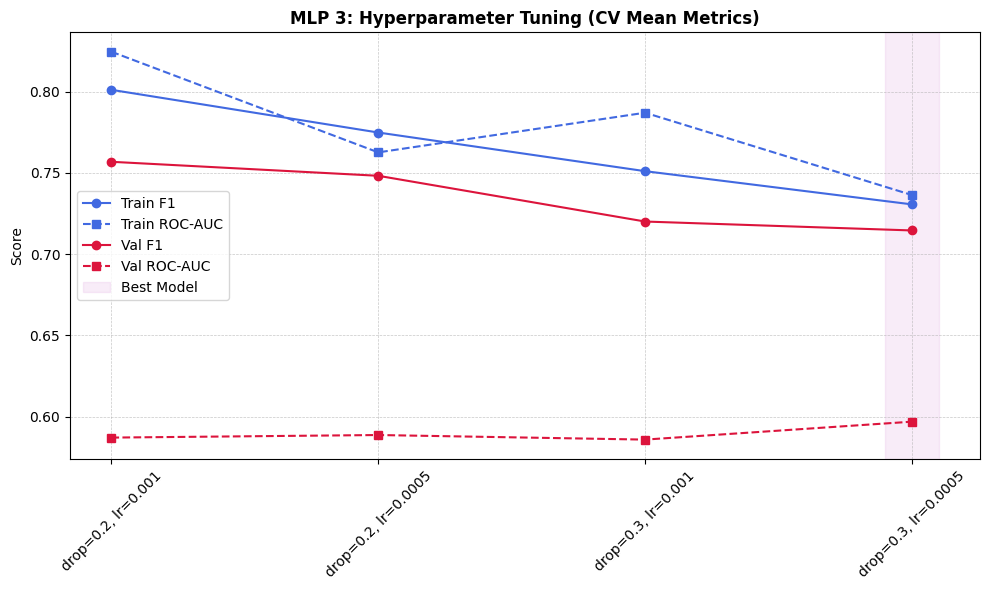

In [23]:
# ========================
# Plot MLP 3 CV Results
# ========================
mlp_3_cv_df["label"] = mlp_3_cv_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(mlp_3_cv_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, mlp_3_cv_df["train_f1_mean"], marker="o", linestyle="-",
         color="RoyalBlue", label="Train F1")
plt.plot(x, mlp_3_cv_df["train_roc_auc_mean"], marker="s", linestyle="--",
         color="RoyalBlue", label="Train ROC-AUC")

# Validation metrics
plt.plot(x, mlp_3_cv_df["val_f1_mean"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, mlp_3_cv_df["val_roc_auc_mean"], marker="s", linestyle="--",
         color="Crimson", label="Val ROC-AUC")

# Highlight best model by val ROC-AUC
best_idx = mlp_3_cv_df["val_roc_auc_mean"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, mlp_3_cv_df["label"], rotation=45)
plt.title("MLP 3: Hyperparameter Tuning (CV Mean Metrics)", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

---
## MLP 4, &ensp; $h = [4, 2]$

For the fourth version of our model, we found our highest ROC_AUC score when our dropout rate was set to
${\color{Gray}{0.3}}$
and our learning rate was set to 
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.001}}$.

Results from our cross-validation folds show that our train set ROC_AUC is at around
$0.66$,
and the validation set is around
$0.58$.
This is similar to what we found in the previous version.

In [24]:
# =========================
# Tuning MLP 4 on 5-fold CV
# =========================
dropouts = [0.2, 0.3]
learning_rates = [0.001, 0.0005]
k_folds = 5

mlp_4_cv_summary = []

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for do in dropouts:
    for lr in learning_rates:
        display(HTML(f"<br><strong>Training MLP 4, &ensp; h = [4, 2]"
                     f"&ensp; with dropout={do}, lr={lr}</strong><br>"))        
        
        fold_train_roc_auc = []
        fold_val_roc_auc = []
        fold_train_f1 = []
        fold_val_f1 = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_enc, y_train)):
            X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Build & compile model
            model = build_mlp_4(input_shape=X_train_enc.shape[1], dropout=do)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss="binary_crossentropy",
                          metrics=[tf.keras.metrics.AUC(name="auc"),
                                   Precision(name="prec"),
                                   Recall(name="rec")])

            early_stop = EarlyStopping(
            monitor="val_roc_auc",
            patience=8,
            mode="max",
            restore_best_weights=True
            )
            
            # Train
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_val, y_val),
                epochs=80,
                batch_size=64,
                verbose=0,
                class_weight=class_weights_dict,
                callbacks=[early_stop] 
            )

            # Predict
            train_probs = model.predict(X_tr, verbose=0).flatten()
            val_probs = model.predict(X_val, verbose=0).flatten()
            train_preds = (train_probs > 0.5).astype(int)
            val_preds = (val_probs > 0.5).astype(int)

            # Compute metrics
            tr_roc_auc = roc_auc_score(y_tr, train_probs)
            val_roc_auc = roc_auc_score(y_val, val_probs)
            tr_f1 = f1_score(y_tr, train_preds)
            val_f1 = f1_score(y_val, val_preds)
            
            fold_train_roc_auc.append(tr_roc_auc)
            fold_val_roc_auc.append(val_roc_auc)
            fold_train_f1.append(tr_f1)
            fold_val_f1.append(val_f1)

            # Track best ROC-AUC for this fold
            print(f"\nFold {fold+1}:")
            print(f"   Train ROC-AUC: {tr_roc_auc:.4f} | Train F1: {tr_f1:.4f}")
            print(f"   Val   ROC-AUC: {val_roc_auc:.4f} | Val   F1: {val_f1:.4f}")

            # Confusion matrix for this fold
            cm = confusion_matrix(y_val, val_preds)
            print("    Confusion Matrix (Val):")
            print(cm)

        # Save mean metrics across folds
        mlp_4_cv_summary.append({
            "dropout_rate": do,
            "lr": lr,
            "train_roc_auc_mean": np.mean(fold_train_roc_auc),
            "val_roc_auc_mean": np.mean(fold_val_roc_auc),
            "train_f1_mean": np.mean(fold_train_f1),
            "val_f1_mean": np.mean(fold_val_f1),
        })

# Convert to DataFrame
mlp_4_cv_df = pd.DataFrame(mlp_4_cv_summary)

# Highlight best mean val ROC-AUC
def highlight_best_val_roc_auc(row):
    if row["val_roc_auc_mean"] == mlp_4_cv_df["val_roc_auc_mean"].max():
        return ["background-color: #F4DCF3"]*len(row)
    return [""]*len(row)


display(HTML(f"<br><strong>Training MLP 4, &ensp; h = [4, 2]"
                     f"&ensp; HyperParameter Summary</strong><br>"))    
display(mlp_4_cv_df.style.apply(highlight_best_val_roc_auc, axis=1))


Fold 1:
   Train ROC-AUC: 0.6798 | Train F1: 0.6199
   Val   ROC-AUC: 0.5765 | Val   F1: 0.6095
    Confusion Matrix (Val):
[[ 66  35]
 [557 462]]

Fold 2:
   Train ROC-AUC: 0.6922 | Train F1: 0.8390
   Val   ROC-AUC: 0.5977 | Val   F1: 0.8280
    Confusion Matrix (Val):
[[ 47  54]
 [261 758]]

Fold 3:
   Train ROC-AUC: 0.6984 | Train F1: 0.6998
   Val   ROC-AUC: 0.6089 | Val   F1: 0.6934
    Confusion Matrix (Val):
[[ 61  40]
 [457 562]]

Fold 4:
   Train ROC-AUC: 0.6872 | Train F1: 0.6393
   Val   ROC-AUC: 0.5939 | Val   F1: 0.6180
    Confusion Matrix (Val):
[[ 69  32]
 [549 470]]

Fold 5:
   Train ROC-AUC: 0.6991 | Train F1: 0.7936
   Val   ROC-AUC: 0.5801 | Val   F1: 0.7657
    Confusion Matrix (Val):
[[ 48  54]
 [353 665]]



Fold 1:
   Train ROC-AUC: 0.6723 | Train F1: 0.7570
   Val   ROC-AUC: 0.5646 | Val   F1: 0.7319
    Confusion Matrix (Val):
[[ 51  50]
 [402 617]]

Fold 2:
   Train ROC-AUC: 0.6649 | Train F1: 0.6888
   Val   ROC-AUC: 0.5874 | Val   F1: 0.6750
    Confusion Matrix (Val):
[[ 62  39]
 [480 539]]

Fold 3:
   Train ROC-AUC: 0.6460 | Train F1: 0.6059
   Val   ROC-AUC: 0.5795 | Val   F1: 0.5780
    Confusion Matrix (Val):
[[ 67  34]
 [591 428]]

Fold 4:
   Train ROC-AUC: 0.6862 | Train F1: 0.7737
   Val   ROC-AUC: 0.6016 | Val   F1: 0.7565
    Confusion Matrix (Val):
[[ 50  51]
 [368 651]]

Fold 5:
   Train ROC-AUC: 0.6766 | Train F1: 0.7689
   Val   ROC-AUC: 0.5908 | Val   F1: 0.7496
    Confusion Matrix (Val):
[[ 54  48]
 [379 639]]



Fold 1:
   Train ROC-AUC: 0.6824 | Train F1: 0.8508
   Val   ROC-AUC: 0.5780 | Val   F1: 0.8446
    Confusion Matrix (Val):
[[ 27  74]
 [220 799]]

Fold 2:
   Train ROC-AUC: 0.6739 | Train F1: 0.6305
   Val   ROC-AUC: 0.6199 | Val   F1: 0.6186
    Confusion Matrix (Val):
[[ 75  26]
 [551 468]]

Fold 3:
   Train ROC-AUC: 0.6716 | Train F1: 0.7427
   Val   ROC-AUC: 0.6256 | Val   F1: 0.7429
    Confusion Matrix (Val):
[[ 59  42]
 [392 627]]

Fold 4:
   Train ROC-AUC: 0.6404 | Train F1: 0.6249
   Val   ROC-AUC: 0.5813 | Val   F1: 0.6202
    Confusion Matrix (Val):
[[ 61  40]
 [543 476]]

Fold 5:
   Train ROC-AUC: 0.6792 | Train F1: 0.7678
   Val   ROC-AUC: 0.6085 | Val   F1: 0.7474
    Confusion Matrix (Val):
[[ 54  48]
 [382 636]]



Fold 1:
   Train ROC-AUC: 0.6604 | Train F1: 0.8799
   Val   ROC-AUC: 0.5170 | Val   F1: 0.8772
    Confusion Matrix (Val):
[[ 18  83]
 [158 861]]

Fold 2:
   Train ROC-AUC: 0.6288 | Train F1: 0.6447
   Val   ROC-AUC: 0.5488 | Val   F1: 0.6260
    Confusion Matrix (Val):
[[ 62  39]
 [537 482]]

Fold 3:
   Train ROC-AUC: 0.6538 | Train F1: 0.6070
   Val   ROC-AUC: 0.5942 | Val   F1: 0.5823
    Confusion Matrix (Val):
[[ 73  28]
 [589 430]]

Fold 4:
   Train ROC-AUC: 0.6376 | Train F1: 0.8263
   Val   ROC-AUC: 0.6027 | Val   F1: 0.8180
    Confusion Matrix (Val):
[[ 42  59]
 [273 746]]

Fold 5:
   Train ROC-AUC: 0.6550 | Train F1: 0.7056
   Val   ROC-AUC: 0.5534 | Val   F1: 0.6985
    Confusion Matrix (Val):
[[ 56  46]
 [447 571]]


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean
0,0.200000,0.001000,0.691325,0.591418,0.718302,0.702913
1,0.200000,0.000500,0.669189,0.584784,0.718845,0.698202
2,0.300000,0.001000,0.669503,0.602652,0.723352,0.714738
3,0.300000,0.000500,0.647140,0.563220,0.732707,0.720384


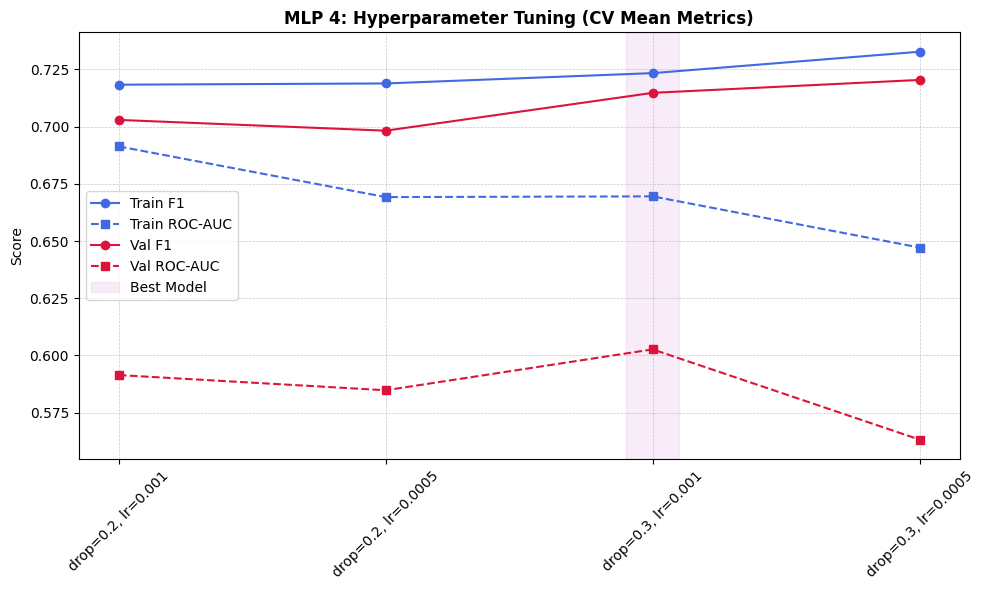

In [25]:
# ========================
# Plot MLP 4 CV Results
# ========================
mlp_4_cv_df["label"] = mlp_4_cv_df.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(mlp_4_cv_df))
plt.figure(figsize=(10,6))

# Train metrics
plt.plot(x, mlp_4_cv_df["train_f1_mean"], marker="o", linestyle="-",
         color="RoyalBlue", label="Train F1")
plt.plot(x, mlp_4_cv_df["train_roc_auc_mean"], marker="s", linestyle="--",
         color="RoyalBlue", label="Train ROC-AUC")

# Validation metrics
plt.plot(x, mlp_4_cv_df["val_f1_mean"], marker="o", linestyle="-",
         color="Crimson", label="Val F1")
plt.plot(x, mlp_4_cv_df["val_roc_auc_mean"], marker="s", linestyle="--",
         color="Crimson", label="Val ROC-AUC")

# Highlight best model by val ROC-AUC
best_idx = mlp_4_cv_df["val_roc_auc_mean"].idxmax()
plt.axvspan(
    best_idx - 0.1,
    best_idx + 0.1,
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, mlp_4_cv_df["label"], rotation=45)
plt.title("MLP 4: Hyperparameter Tuning (CV Mean Metrics)", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

<br>

---
---
# **5.  Conclusion**

---
## Final Results

The final ROC_AUC scores and F1 scores for all our models are shown in the tables below. The highest validation set ROC_AUC score for each model is marked in Plum.

In [26]:
def highlight_best_val_roc_auc(df):
    def _highlight(row):
        if row["val_roc_auc_mean"] == df["val_roc_auc_mean"].max():
            return ["background-color: #F4DCF3"] * len(row)
        return [""] * len(row)
    return _highlight

# MLP 1, h = [256, 128]
display(HTML(f"<br><strong>Training MLP 1, &ensp; h = [256, 128]</strong>"))
display(mlp_1_cv_df.style.apply(highlight_best_val_roc_auc(mlp_1_cv_df), axis=1))

# MLP 2, h = [64, 32]
display(HTML(f"<br><strong>Training MLP 2, &ensp; h = [64, 32]</strong>"))
display(mlp_2_cv_df.style.apply(highlight_best_val_roc_auc(mlp_2_cv_df), axis=1))

# MLP 3, h = [16, 8]
display(HTML(f"<br><strong>Training MLP 3, &ensp; h = [16, 8]</strong>"))
display(mlp_3_cv_df.style.apply(highlight_best_val_roc_auc(mlp_3_cv_df), axis=1))

# MLP 4, h = [4, 2]
display(HTML(f"<br><strong>Training MLP 4, &ensp; h = [4, 2]</strong>"))
display(mlp_4_cv_df.style.apply(highlight_best_val_roc_auc(mlp_4_cv_df), axis=1))

,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean,label
0,0.200000,0.001000,0.999937,0.553517,0.996997,0.914193,"drop=0.2, lr=0.001"
1,0.200000,0.000500,0.999951,0.528002,0.995015,0.909328,"drop=0.2, lr=0.0005"
2,0.300000,0.001000,0.999758,0.545903,0.992384,0.905746,"drop=0.3, lr=0.001"
3,0.300000,0.000500,0.999506,0.537038,0.985656,0.903324,"drop=0.3, lr=0.0005"


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean,label
0,0.200000,0.001000,0.985178,0.559396,0.928203,0.841853,"drop=0.2, lr=0.001"
1,0.200000,0.000500,0.957882,0.554134,0.906349,0.837793,"drop=0.2, lr=0.0005"
2,0.300000,0.001000,0.963525,0.563268,0.905271,0.830760,"drop=0.3, lr=0.001"
3,0.300000,0.000500,0.918561,0.563967,0.862625,0.800542,"drop=0.3, lr=0.0005"


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean,label
0,0.200000,0.001000,0.824556,0.587177,0.801124,0.756847,"drop=0.2, lr=0.001"
1,0.200000,0.000500,0.762636,0.588755,0.774853,0.748237,"drop=0.2, lr=0.0005"
2,0.300000,0.001000,0.787034,0.585939,0.751074,0.720093,"drop=0.3, lr=0.001"
3,0.300000,0.000500,0.736404,0.596971,0.730641,0.714605,"drop=0.3, lr=0.0005"


,dropout_rate,lr,train_roc_auc_mean,val_roc_auc_mean,train_f1_mean,val_f1_mean,label
0,0.200000,0.001000,0.691325,0.591418,0.718302,0.702913,"drop=0.2, lr=0.001"
1,0.200000,0.000500,0.669189,0.584784,0.718845,0.698202,"drop=0.2, lr=0.0005"
2,0.300000,0.001000,0.669503,0.602652,0.723352,0.714738,"drop=0.3, lr=0.001"
3,0.300000,0.000500,0.647140,0.563220,0.732707,0.720384,"drop=0.3, lr=0.0005"


Our best performing model was MLP 3 with the hyperparameters set to `dropout_rate=0.3` and `lr=0.0005`. Below, we run this model on our test set and generate a csv with our submission values.

In [29]:
# =========================
# Run Best Model MLP 3 on train set + valid set
# =========================
best_dropout = 0.3
best_lr = 0.0005

display(HTML(f"<strong>Training BEST model &emsp; MLP 6, &ensp; h = [16, 8]"
             f"&ensp; with dropout=0.3, lr=0.0005</strong>"))

best_model = build_mlp_3(
    input_shape=X_train_enc.shape[1],
    dropout=best_dropout
)

best_model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"),
             Precision(name="prec"),
             Recall(name="rec")]
)

early_stop = EarlyStopping(
    monitor="val_auc",
    patience=10,
    mode="max",
    restore_best_weights=True
)

history = best_model.fit(
    X_train_enc, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


# =========================
# Run Best Model MLP 3 on test set
# =========================

test_probs = best_model.predict(X_test_enc, verbose=0).flatten()

submission_df = pd.DataFrame({
    "patient_id": test_raw["patient_id"],
    "target": test_probs
})

# -------------------------
# Generate submission
# -------------------------
display(HTML(f"<strong>Test MLP 3, &ensp; h = [16, 8]"
             f"&ensp; with dropout=0.3, lr=0.0005</strong>"))
display(submission_df.head())
submission_path = "submission.csv"
submission_df.to_csv(submission_path, index=False)

Epoch 1/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - auc: 0.5082 - loss: 0.8606 - prec: 0.9172 - rec: 0.4846 - val_auc: 0.5354 - val_loss: 0.7008 - val_prec: 0.9033 - val_rec: 0.4850
Epoch 2/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5356 - loss: 0.8454 - prec: 0.9200 - rec: 0.5130 - val_auc: 0.5456 - val_loss: 0.7110 - val_prec: 0.9086 - val_rec: 0.4760
Epoch 3/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5696 - loss: 0.7475 - prec: 0.9363 - rec: 0.5094 - val_auc: 0.5478 - val_loss: 0.7113 - val_prec: 0.9107 - val_rec: 0.4990
Epoch 4/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5287 - loss: 0.8196 - prec: 0.9162 - rec: 0.5056 - val_auc: 0.5510 - val_loss: 0.7150 - val_prec: 0.9079 - val_rec: 0.5020
Epoch 5/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5581 - loss: 0.7781 - prec: 0.9274 - rec: 0.5179 - val_auc: 0.5599 - val_loss: 0.7111 - val_prec: 0.9122 - val_rec: 0.5289
Epoch 6/80
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5578 - loss: 0.7636 - prec: 0.

,patient_id,target
0,5526,0.760540
1,772,0.632438
2,7840,0.498146
3,2396,0.637033
4,1479,0.595650


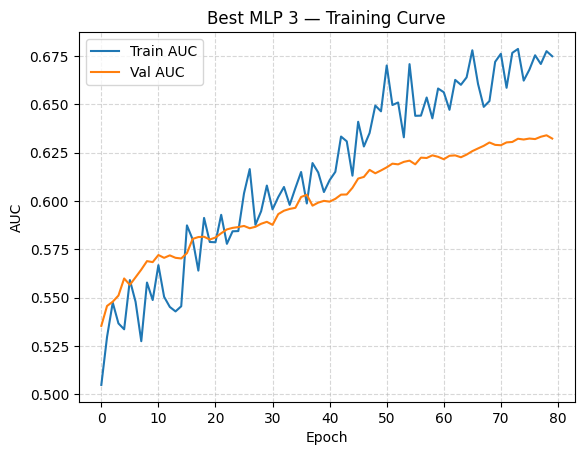

In [30]:
# =========================
# Final Plot
# =========================
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.title("Best MLP 3 — Training Curve")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

---
## Discussion

After running several MLP models, we learned that having too many hidden states within our dense layers puts the model at risk of overfitting, especially when when out dataset is under relatively small. In our case, our validation set was only
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{1400}}$,
while our train set was much larger at
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{5600}}$.
This explains why having hundreds of hidden states at the dense layers during early model versions caused severe overfitting on the train set, like we say with our iterations of MLP 1. There, we had a train set ROC_AUC score of
$1.0$
and a validation set ROC_AUC score of only
$0.53$.

Reducing the number of hidden states to
${\color{CornflowerBlue}{h}}_{3}
    = [ {\color{CornflowerBlue}{16}}, \, {\color{CornflowerBlue}{8}} ]$
improved these overfitting issues. By the time reached our third version, MLP 3, our maximum validation set ROC_AUC score hovered around
$0.59$,
with a corresponding train set ROC_AUC score of
$0.78$.

For that particular model, we found the best results at a dropout rate of
${\color{Gray}{0.3}}$
and a learning rate of
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$.
This shows that increasing the dropout rate to avoid overfitting helps improve model performance, while decreasing the learning rate allows it to reach convergence faster.

To make future improvements to this model, I would go wider rather than deeper. I would keep the number of hidden states at each Dense Layer to
${\color{CornflowerBlue}{h}}
    = [ {\color{CornflowerBlue}{16}}, \, {\color{CornflowerBlue}{8}} ]$,
but I would have multiple Dense layers and input a different slice of our input at each one. The manual slicing I did by group + encoding during the EDA phase of this project would be a good starting point.

---
# 6. Resources

* Barbosa, F. T. (2025). Dental Implant 10-Year Survival Prediction. https://kaggle.com/competitions/dental-implant-10-year-survival-prediction